# Importing necessary libraries

In [1]:
%pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-2yc144z2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-2yc144z2
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
# @title Imports

import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torch
import torchvision
from torchvision.datasets.flowers102 import Flowers102
from torch.utils.data import Dataset
import torch.nn.functional as F
from tqdm import tqdm
from torch import nn, optim
import clip
import random
import numpy as np
from PIL import Image
import copy
from itertools import chain
import json
import itertools
from datetime import datetime


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 43

## Utility Functions

In [3]:
# @title Generic Utilities
# -- Reproducibility utils --

def set_seed(seed: int = 42):
    """
    Settings used for reproducibility purposes.
    https://pytorch.org/docs/stable/notes/randomness.html
    """
    # Python & NumPy
    random.seed(seed)
    np.random.seed(seed)

    # Torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Torch determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"[INFO] Seed set to {seed}")


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def base_novel_categories(dataset) -> tuple[list[int], list[int]]:
    # set returns the unique set of all dataset classes
    all_classes = set(dataset._labels)
    # and let's count them
    num_classes = len(all_classes)

    # here list(range(num_classes)) returns a list from 0 to num_classes - 1
    # then we slice the list in half and generate base and novel category lists
    base_classes = list(range(num_classes))[:num_classes // 2]
    novel_classes = list(range(num_classes))[num_classes // 2:]
    return base_classes, novel_classes


def harmonic_mean(base_accuracy, novel_accuracy):
    numerator = 2
    denominator = 1 / base_accuracy + 1 / novel_accuracy
    hm = numerator / denominator
    return hm


def get_data(data_dir='./data', transform=None) -> tuple[Flowers102,
                                                         Flowers102,
                                                         Flowers102]:
    """Load Flowers102 train, validation and test sets.
    Args:
        data_dir (str): Directory where the dataset will be stored.
        transform (torch.Compose)
    Returns:
        tuple: A tuple containing the train, validation, and test sets.
    """
    train = Flowers102(
        root=data_dir, split="train", download=True, transform=transform)
    val = Flowers102(
        root=data_dir, split="val", download=True, transform=transform)
    test = Flowers102(
        root=data_dir, split="test", download=True, transform=transform)
    return train, val, test


def split_data(dataset, base_classes):
    # these two lists will store the sample indexes
    base_categories_samples = []
    novel_categories_samples = []

    # we create a set of base classes to compute the test below in O(1)
    # this is optional and can be removed
    base_set = set(base_classes)

    # here we iterate over sample labels and also get the correspondent sample index
    for sample_id, label in enumerate(dataset._labels):
        if label in base_set:
            base_categories_samples.append(sample_id)
        else:
            novel_categories_samples.append(sample_id)

    # here we create the dataset subsets
    # the torch Subset is just a wrapper around the dataset
    # it simply stores the subset indexes and the original dataset (your_subset.dataset)
    # when asking for sample i in the subset, torch will look for its original position in the dataset and retrieve it
    # https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset
    base_dataset = torch.utils.data.Subset(dataset, base_categories_samples)
    novel_dataset = torch.utils.data.Subset(dataset, novel_categories_samples)
    return base_dataset, novel_dataset


class RemappedDataset(torch.utils.data.Dataset):
    """Wrapper to remap labels to contiguous range [0, num_classes-1]"""

    def __init__(self, subset, class_indices):
        self.subset = subset
        # Create mapping: original_label -> new_label (0-indexed)
        self.label_map = {orig: new for new, orig in enumerate(sorted(class_indices))}

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, original_label = self.subset[idx]
        # Remap label to 0-indexed range
        remapped_label = self.label_map[original_label]
        return image, remapped_label


def accuracy(logits: torch.Tensor, labels: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()


@torch.no_grad()
def eval_with_class_subset(model, dataloader, class_indices):
    model.eval()
    total_loss, total_acc = 0.0, 0.0

    for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        logit_scale = student_model.logit_scale.exp()

        # get full predictions
        img_feats, text_feats = model(images)
        # print(f"text features shape {text_feats.shape}")

        # getting only the text features for the relevant classes
        text_feats = text_feats[class_indices, :]

        # print(f"selected text features shape {text_feats.shape}")

        logits = logit_scale * img_feats @ text_feats.t()
        loss = F.cross_entropy(logits, labels)

        total_loss += loss.item()
        total_acc += accuracy(logits, labels)

    return total_loss / len(dataloader), total_acc / len(dataloader)

In [4]:
# @title Training Utilities
def train_one_epoch(
    teacher_model,
    student_model,
    dataloader,
    optimizer,
    base_indices,
    teacher_text_feats, # never change during training
    alpha=0.5,
    beta=0.2,
    temperature=2.0
):
    teacher_model.train()
    total_loss, total_acc = 0.0, 0.0

    # selecting base classes text_features ONLY
    teacher_text_feats = teacher_text_feats[base_indices, :]

    for imgs, labels in tqdm(dataloader, desc="Training", leave=False):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        # student forward pass
        student_img_feats, student_text_feats = student_model(imgs)  #  img feats shape: [B, 512], txt feats shape: [102, 512]
        # print("student text_features shape: ", student_text_feats.shape)

        # retrieving base classes text features ONLY
        student_text_feats = student_text_feats[base_indices, :]  # shape: (51, 512)

        # teacher forward pass
        with torch.no_grad():
            dtype = teacher_model.dtype
            teacher_img_feats = teacher_model.visual(imgs.type(dtype))
            teacher_img_feats /= teacher_img_feats.norm(dim=-1, keepdim=True).clamp(min=1e-12)
            # print("teacher text_features shape: ", teacher_text_feats.shape)

        # calculate student and teacher logits
        logit_scale = student_model.logit_scale.exp()
        student_logits = logit_scale * student_img_feats @ student_text_feats.t()
        # note: vision logits are the cos. sim between teacher img feats (non adapted) and student text feats (adapted with CoOp).
        teacher_vision_logits = logit_scale * teacher_img_feats @ student_text_feats.t()

        # CE loss on base classes only
        ce_loss = F.cross_entropy(student_logits, labels)

        # visual distillation loss (KL div.) with temperature
        vision_kl_loss = F.kl_div(
            F.log_softmax(student_logits / temperature, dim=-1),
            F.softmax(teacher_vision_logits / temperature, dim=-1),
            reduction='batchmean'
        ) * (temperature ** 2)

        # text feature-based KD loss
        text_kd_loss = 1 - F.cosine_similarity(
            student_text_feats, teacher_text_feats, dim=-1
        ).mean()

        # combined loss (vision_KD + text_KD + CE)
        loss = (alpha * ce_loss + (1 - alpha) * vision_kl_loss) + beta * text_kd_loss # (visual KL + CE + text KD)
        #loss = (alpha * ce_loss + (1 - alpha) * vision_kl_loss) # (visual KL + CE)
        #loss = ce_loss + beta * text_kd_loss # (CE + text KD)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy(student_logits, labels)

    return total_loss / len(dataloader), total_acc / len(dataloader)


def train_loop(
    teacher_model,
    student_model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    base_indices,
    epochs=10,
    alpha=0.5,
    beta=0.2,
    temperature=2,
    model_state_path='adapter_weights.pt'
):
    best_val_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # pre-computing CLIP frozen language features such that to avoid re-computing them at each epoch
    with torch.no_grad():
        dtype = teacher_model.dtype
        classnames = student_model.classnames
        template = "a photo of a {}, a type of flower."
        prompts = [template.format(c) for c in classnames]
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(DEVICE)
        teacher_text_feats = teacher_model.encode_text(tokenized_prompts)
        teacher_text_feats /= teacher_text_feats.norm(dim=-1, keepdim=True).clamp(min=1e-12) # normalize

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch: {epoch}/{epochs}")

        train_loss, train_acc = train_one_epoch(
            teacher_model, student_model, train_loader, optimizer,
            base_indices, teacher_text_feats, alpha, beta, temperature
        )
        val_loss, val_acc = eval_with_class_subset(student_model, val_loader, base_indices)

        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        print(f"[LR] Current learning rate: {current_lr:.6f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc.: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc.: {val_acc:.4f}")

        # save model    
        best_val_acc = val_acc
        best_vision_adapter_state = copy.deepcopy(student_model.vision_adapter.state_dict())
        best_ctx_state = copy.deepcopy(student_model.text_adapter.state_dict())
        torch.save(best_ctx_state, "ctx_state.pt")
        torch.save(best_vision_adapter_state, "vision_adapter_state.pt")
        print(f"✅ New model saved (val_acc = {best_val_acc:.4f})")


    return history

# Model Definition

### CLIP-Adapter

In [5]:
# @title Adapters (CoOp and CLIP-Adapter)

class VisionAdapter(nn.Module):
    def __init__(self, c_in, reduction=4, dropout=0.5):
        super(VisionAdapter, self).__init__()

        hidden_dim = c_in // reduction
        self.net = nn.Sequential(
            nn.Linear(in_features=c_in, out_features=hidden_dim, bias=False),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=hidden_dim, out_features=c_in, bias=False),
        )

    def forward(self, x):
        x = self.net(x)  # residual
        return x


class TextAdapter(nn.Module): # CoOp text adapter
    def __init__(self, classnames, clip_model, n_ctx=16):
        super(TextAdapter, self).__init__()
        self.classnames = classnames
        self.dtype = clip_model.dtype

        ctx_dim = clip_model.ln_final.weight.shape[0]  # context dimension
        self.ctx = nn.Parameter(torch.empty(n_ctx, ctx_dim))  # tokens to be learned
        nn.init.normal_(self.ctx, std=0.02)

        prompt_prefix = " ".join(['X'] * n_ctx)
        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        temp = 'a photo of a {}, a type of flower.'
        prompts = [temp.format(c) for c in classnames]
        prompts = [prompt_prefix + " " + p for p in prompts]
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(DEVICE)

        with torch.no_grad():
            embeddings = clip_model.token_embedding(tokenized_prompts).type(self.dtype)

        # structure is: [BOS] [class tokens ... ] [EOS]
        self.register_buffer("token_prefix", embeddings[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embeddings[:, 1 + n_ctx :, :])  # class tokens + EOS
        self.tokenized_prompts = tokenized_prompts

    def forward(self, token_embeddings):
        # append the learnable context to the end of the token embeddings
        ctx = self.ctx.unsqueeze(0).expand(token_embeddings.shape[0], -1, -1)
        return torch.cat([
            self.token_prefix,  # BOS
            ctx,  # learned context
            self.token_suffix,  # class tokens + EOS
        ], dim=1).type(self.dtype)


### Custom CLIP

In [6]:
# @title CustomCLIP

class CustomCLIP(nn.Module): # Student model with both visual and text adapters
    def __init__(
        self,
        classnames: list[str],
        clip_model: nn.Module,
        vision_adapter_args,
        text_adapter_args,
        vision_ratio: float = 0.2,
        vision_adapter_state=None,
        text_adapter_state=None 
    ):
        super().__init__()
        self.classnames = classnames
        self.dtype = clip_model.dtype
        self.clip_model = clip_model
        self.vision_ratio = vision_ratio
        self.logit_scale = clip_model.logit_scale
        self.image_encoder = clip_model.visual

        # create and attach adapters
        vision_feature_dim = self.image_encoder.output_dim
        self.vision_adapter = VisionAdapter(vision_feature_dim, **vision_adapter_args)
        self.text_adapter = TextAdapter(classnames, clip_model, **text_adapter_args)

        if vision_adapter_state:
            self.vision_adapter.load_state_dict(vision_adapter_state)

        if text_adapter_state:
            self.text_adapter.load_state_dict(text_adapter_state)

    def encode_image_with_adapter(self, image):
        image_features = self.image_encoder(image.type(self.dtype))
        adapted_features = self.vision_adapter(image_features.float()).type(self.dtype)
        combined_features = self.vision_ratio * adapted_features + (1 - self.vision_ratio) * image_features
        # norm & return
        return combined_features / combined_features.norm(dim=-1, keepdim=True)

    def encode_text_with_adapter(self):
        text_embeddings = self.clip_model.token_embedding(
            self.text_adapter.tokenized_prompts).type(self.dtype)
        adapted_embeddings = self.text_adapter(text_embeddings)

        # pass through CLIP text transformer
        x = adapted_embeddings + self.clip_model.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.clip_model.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.clip_model.ln_final(x).type(self.dtype)

        text_features = x[torch.arange(x.shape[0]), self.text_adapter.tokenized_prompts.argmax(dim=-1)] @ self.clip_model.text_projection
        return text_features / text_features.norm(dim=-1, keepdim=True)

    def forward(self, images: torch.Tensor):
        # compute (normalized) text & image feats.
        image_features = self.encode_image_with_adapter(images.type(self.dtype))
        text_features = self.encode_text_with_adapter()
        return image_features, text_features

# Preparing the Dataset and CLIP

In [7]:
set_seed(SEED)

# Inspect classes
_, _, tmp_test = get_data()
base_classes, novel_classes = base_novel_categories(tmp_test)

CLASS_NAMES = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold',
    'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
    'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
    'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
    'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
    'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william',
    'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly',
    'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose',
    'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue',
    'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
    'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium',
    'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
    'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy',
    'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy',
    'gazania', 'azalea', 'water lily', 'rose', 'thorn apple',
    'morning glory', 'passion flower', 'lotus lotus', 'toad lily', 'anthurium',
    'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose',
    'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily',
    'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea',
    'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower',
    'trumpet creeper', 'blackberry lily'
]

# available models = ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
clip_model, preprocess = clip.load("ViT-B/16", device=DEVICE)

# get the three datasets
train_set, val_set, test_set = get_data(transform=preprocess)

# split classes into base and novel
base_classes, novel_classes = base_novel_categories(train_set)

# split the three datasets
train_base, _ = split_data(train_set, base_classes)
val_base, _ = split_data(val_set, base_classes)
test_base, test_novel = split_data(test_set, base_classes)

# Create data loaders
g = torch.Generator()
g.manual_seed(SEED)

BATCH_SIZE = 32

[INFO] Seed set to 43


# Preparing the custom Model + Hyperparameter Tuning
The idea to tune the various loss weights i.e. $\mathbf{\alpha}$ and $\mathbf{\beta}$ is to split the original base set into two subsets and treat the first half as the "meta" base set and the second half as the "meta" novel set. By doing this, we can effectively perform an exhaustive hyperparameter search using the validation set of the "meta" novel set without ever leaking data from the actual novel set.

In [8]:
epochs = 15
lr = 2e-3
wd = 1e-2
# vision adapter hyperparams.
vision_ratio = 0.2  # original paper is 0.2
vision_reduction = 16
vision_dropout = 0.4
vision_adapter_args = {"reduction": vision_reduction, "dropout": vision_dropout}
# CoOp hyperparam
n_ctx = 16
text_adapter_args = {"n_ctx": n_ctx}
temperature = 3

# loss weights search space
alpha_values = [0.1, 0.15, 0.2, 0.4, 0.6, 0.8]
beta_values = [0.5, 1, 2, 4, 8]

# generate all parameter combinations
param_combinations = list(itertools.product(alpha_values, beta_values))

print("Number of experiments to run: ", len(param_combinations))
print(f"Alpha values: {alpha_values}")
print(f"Beta values: {beta_values}")

results = {
    "metadata": {
        "timestamp": datetime.now().isoformat(),
        "model_config": {
            "epochs": epochs,
            "lr": lr,
            "weight_decay": wd,
            "vision_ratio": vision_ratio,
            "vision_reduction": vision_reduction,
            "vision_dropout": vision_dropout,
            "n_ctx": n_ctx,
            "temperature": temperature,
            "batch_size": BATCH_SIZE,
            "seed": SEED
        },
        "search_space": {
            "alpha_values": alpha_values,
            "beta_values": beta_values
        }
    },
    "experiments": []
}

n_splits = 3  # the higher the better for robustness but the higher in terms of computational resources.

# define dataloaders for testing
test_base_loader = torch.utils.data.DataLoader(
    test_base,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    generator=g
)
test_novel_loader = torch.utils.data.DataLoader(
    test_novel,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    generator=g
)

# defining teacher once (CLIP base)
teacher_model = clip_model
teacher_model.eval()

# freezing teacher params
for param in teacher_model.parameters():
    param.requires_grad = False

for exp_idx, (alpha, beta) in enumerate(param_combinations, 1):
    base_split_scores = []
    novel_split_scores = []
    hm_split_scores = []

    for split_idx in range(n_splits):
        print(f"\n{'='*60}")
        print(f"Experiment {exp_idx}/{len(param_combinations) * n_splits}")
        print(f"Split: {split_idx + 1}, Alpha: {alpha}, Beta: {beta}")
        print(f"{'='*60}")

        # Random split of base classes (51) into meta-train (25) and meta-val (26)
        np.random.seed(SEED + split_idx)
        shuffled_base = np.array(base_classes.copy())
        np.random.shuffle(shuffled_base)

        # IMPORTANT: Sort the classes so they match RemappedDataset's internal sorting
        meta_base_classes = sorted(shuffled_base[:25].tolist())
        meta_novel_classes = sorted(shuffled_base[25:].tolist())

        # create subsets
        train_meta_base, _ = split_data(train_set, meta_base_classes)
        val_meta_base, _ = split_data(val_set, meta_base_classes)
        val_meta_novel, _ = split_data(val_set, meta_novel_classes)

        # Wrap with RemappedDataset to remap labels to 0-indexed
        train_meta_base = RemappedDataset(train_meta_base, meta_base_classes)
        val_meta_base = RemappedDataset(val_meta_base, meta_base_classes)
        val_meta_novel = RemappedDataset(val_meta_novel, meta_novel_classes)

        # create dataloaders
        train_meta_base_loader = torch.utils.data.DataLoader(
            train_meta_base,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=2,
            generator=g,
            worker_init_fn=seed_worker
        )

        val_meta_base_loader = torch.utils.data.DataLoader(
            val_meta_base,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=2,
            generator=g,
            worker_init_fn=seed_worker
        )

        val_meta_novel_loader = torch.utils.data.DataLoader(
            val_meta_novel,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=2,
            generator=g,
            worker_init_fn=seed_worker
        )

        set_seed(SEED)

        # defining student model
        student_model = CustomCLIP(
            CLASS_NAMES,
            clip_model,
            vision_adapter_args=vision_adapter_args,
            text_adapter_args=text_adapter_args,
            vision_ratio=vision_ratio
        ).to(DEVICE)

        trainable_params = chain(
            student_model.vision_adapter.parameters(),
            student_model.text_adapter.parameters(),
        )

        optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=wd)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        # train
        history = train_loop(
            teacher_model, student_model, train_meta_base_loader,
            val_meta_base_loader, optimizer, scheduler, epochs=epochs,
            base_indices=meta_base_classes, alpha=alpha, beta=beta,
            temperature=temperature
        )

        # load model and evaluate
        vision_adapter_state = torch.load("vision_adapter_state.pt", weights_only=True)
        text_adapter_state = torch.load("ctx_state.pt", weights_only=True)
        best_model = CustomCLIP(
            CLASS_NAMES,
            clip_model,
            vision_adapter_args,
            text_adapter_args,
            vision_ratio,
            vision_adapter_state=vision_adapter_state,
            text_adapter_state=text_adapter_state
        ).to(DEVICE)

        # Evaluate on meta eval sets
        _, meta_base_acc = eval_with_class_subset(best_model, val_meta_base_loader, meta_base_classes)
        _, meta_novel_acc = eval_with_class_subset(best_model, val_meta_novel_loader, meta_novel_classes)
        meta_hm = harmonic_mean(meta_base_acc, meta_novel_acc)

        base_split_scores.append(meta_base_acc)
        novel_split_scores.append(meta_novel_acc)
        hm_split_scores.append(meta_hm)

        print(f"\n📊 Split {split_idx + 1} Results:")
        print(f"  (Meta)-Base Accuracy: {meta_base_acc*100:.2f}%")
        print(f"  (Meta)-Novel Accuracy: {meta_novel_acc*100:.2f}%")
        print(f"  (Meta)-Harmonic Mean: {meta_hm*100:.2f}%")

    # average across splits and compute std between the splits
    base_mean_score = np.mean(base_split_scores)
    novel_mean_score = np.mean(novel_split_scores)
    hm_mean_score = np.mean(hm_split_scores)
    base_std_score = np.std(base_split_scores)
    novel_std_score = np.std(novel_split_scores)
    hm_std_score = np.std(hm_split_scores)

    # save results
    experiment_result = {
        "exp_id": exp_idx,
        "hyperparameters": {
            "alpha": alpha,
            "beta": beta
        },
        "metrics": {
            "base_accuracy_mean": float(base_mean_score),
            "base_accuracy_std": float(base_std_score),
            "novel_accuracy_mean": float(novel_mean_score),
            "novel_accuracy_std": float(novel_std_score),
            "harmonic_mean": float(hm_mean_score),
            "harmonic_mean_std": float(hm_std_score),
            "epochs_trained": len(history["train_loss"])
        },
        "split_scores": {
            "base_scores": [float(x) for x in base_split_scores],
            "novel_scores": [float(x) for x in novel_split_scores],
            "hm_scores": [float(x) for x in hm_split_scores]
        },
        "history": {
            "train_loss": [float(x) for x in history["train_loss"]],
            "train_acc": [float(x) for x in history["train_acc"]],
            "val_loss": [float(x) for x in history["val_loss"]],
            "val_acc": [float(x) for x in history["val_acc"]]
        }
    }

    results["experiments"].append(experiment_result)

    # Print summary
    print(f"\n📊 Experiment {exp_idx} Results (averaged over {n_splits} splits):")
    print(f"  Base Accuracy: {base_mean_score*100:.2f}% (±{base_std_score*100:.2f}%)")
    print(f"  Novel Accuracy: {novel_mean_score*100:.2f}% (±{novel_std_score*100:.2f}%)")
    print(f"  Harmonic Mean: {hm_mean_score*100:.2f}% (±{hm_std_score*100:.2f}%)")

    # Save intermediate results (in case of interruption)
    with open(f"hyperparam_study_results_intermediate.json", "w") as f:
        json.dump(results, f, indent=2)

# Save final results
output_filename = f"hyperparam_study_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(output_filename, "w") as f:
    json.dump(results, f, indent=2)

print(f"\n{'='*60}")
print(f"✅ Study complete! Results saved to: {output_filename}")
print(f"{'='*60}")

# Print top 5 configurations
print("\n🏆 Top 5 Configurations (by Harmonic Mean):")
sorted_results = sorted(results["experiments"],
                       key=lambda x: x["metrics"]["harmonic_mean"],
                       reverse=True)

for i, exp in enumerate(sorted_results[:5], 1):
    print(f"\n{i}. Alpha: {exp['hyperparameters']['alpha']}, "
          f"Beta: {exp['hyperparameters']['beta']}")
    print(f"   Base: {exp['metrics']['base_accuracy_mean']*100:.2f}% (±{exp['metrics']['base_accuracy_std']*100:.2f}%), "
          f"Novel: {exp['metrics']['novel_accuracy_mean']*100:.2f}% (±{exp['metrics']['novel_accuracy_std']*100:.2f}%), "
          f"HM: {exp['metrics']['harmonic_mean']*100:.2f}% (±{exp['metrics']['harmonic_mean_std']*100:.2f}%)")

Number of experiments to run:  30
Alpha values: [0.1, 0.15, 0.2, 0.4, 0.6, 0.8]
Beta values: [0.5, 1, 2, 4, 8]

Experiment 1/90
Split: 1, Alpha: 0.1, Beta: 0.5
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.1947 | Train Acc.: 0.7263
Val Loss: 0.7050 | Val Acc.: 0.8086
✅ New model saved (val_acc = 0.8086)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1119 | Train Acc.: 0.7503
Val Loss: 0.5404 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.0868 | Train Acc.: 0.8332
Val Loss: 0.4208 | Val Acc.: 0.8867
✅ New model saved (val_acc = 0.8867)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.0701 | Train Acc.: 0.8975
Val Loss: 0.3036 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0586 | Train Acc.: 0.9336
Val Loss: 0.2943 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0510 | Train Acc.: 0.9357
Val Loss: 0.2626 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0475 | Train Acc.: 0.9288
Val Loss: 0.2553 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0438 | Train Acc.: 0.9534
Val Loss: 0.2268 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0420 | Train Acc.: 0.9492
Val Loss: 0.2406 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0391 | Train Acc.: 0.9709
Val Loss: 0.2117 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0377 | Train Acc.: 0.9757
Val Loss: 0.2249 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0366 | Train Acc.: 0.9844
Val Loss: 0.2035 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0354 | Train Acc.: 0.9805
Val Loss: 0.2053 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0349 | Train Acc.: 0.9826
Val Loss: 0.2066 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0343 | Train Acc.: 0.9883
Val Loss: 0.2061 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 96.48%
  (Meta)-Novel Accuracy: 83.68%
  (Meta)-Harmonic Mean: 89.63%

Experiment 1/90
Split: 2, Alpha: 0.1, Beta: 0.5
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.1902 | Train Acc.: 0.7389
Val Loss: 0.5672 | Val Acc.: 0.7930
✅ New model saved (val_acc = 0.7930)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1044 | Train Acc.: 0.7936
Val Loss: 0.4286 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.0774 | Train Acc.: 0.8684
Val Loss: 0.2931 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.0627 | Train Acc.: 0.9056
Val Loss: 0.2274 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0522 | Train Acc.: 0.9600
Val Loss: 0.1994 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0454 | Train Acc.: 0.9883
Val Loss: 0.1527 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0419 | Train Acc.: 0.9757
Val Loss: 0.1527 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0368 | Train Acc.: 0.9844
Val Loss: 0.1488 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0336 | Train Acc.: 0.9835
Val Loss: 0.1276 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0319 | Train Acc.: 0.9844
Val Loss: 0.1290 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0297 | Train Acc.: 0.9922
Val Loss: 0.1193 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0289 | Train Acc.: 0.9922
Val Loss: 0.1221 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0285 | Train Acc.: 0.9913
Val Loss: 0.1138 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0281 | Train Acc.: 0.9913
Val Loss: 0.1148 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0277 | Train Acc.: 0.9922
Val Loss: 0.1153 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 98.05%
  (Meta)-Novel Accuracy: 85.42%
  (Meta)-Harmonic Mean: 91.30%

Experiment 1/90
Split: 3, Alpha: 0.1, Beta: 0.5
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.1667 | Train Acc.: 0.7641
Val Loss: 0.4521 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.0889 | Train Acc.: 0.8293
Val Loss: 0.3918 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.0734 | Train Acc.: 0.8462
Val Loss: 0.3637 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.0621 | Train Acc.: 0.9014
Val Loss: 0.3091 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0538 | Train Acc.: 0.9288
Val Loss: 0.2679 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0480 | Train Acc.: 0.9522
Val Loss: 0.2545 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0421 | Train Acc.: 0.9570
Val Loss: 0.2427 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0376 | Train Acc.: 0.9600
Val Loss: 0.2283 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0346 | Train Acc.: 0.9718
Val Loss: 0.2227 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0326 | Train Acc.: 0.9766
Val Loss: 0.2122 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0309 | Train Acc.: 0.9805
Val Loss: 0.2097 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0300 | Train Acc.: 0.9805
Val Loss: 0.2090 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0294 | Train Acc.: 0.9844
Val Loss: 0.2048 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0294 | Train Acc.: 0.9874
Val Loss: 0.2056 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0294 | Train Acc.: 0.9883
Val Loss: 0.2055 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 96.09%
  (Meta)-Novel Accuracy: 80.90%
  (Meta)-Harmonic Mean: 87.85%

📊 Experiment 1 Results (averaged over 3 splits):
  Base Accuracy: 96.88% (±0.84%)
  Novel Accuracy: 83.33% (±1.86%)
  Harmonic Mean: 89.59% (±1.41%)

Experiment 2/90
Split: 1, Alpha: 0.1, Beta: 1
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.2496 | Train Acc.: 0.7037
Val Loss: 0.7102 | Val Acc.: 0.7686
✅ New model saved (val_acc = 0.7686)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1370 | Train Acc.: 0.7524
Val Loss: 0.6115 | Val Acc.: 0.8203
✅ New model saved (val_acc = 0.8203)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1074 | Train Acc.: 0.7954
Val Loss: 0.5225 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.0825 | Train Acc.: 0.8263
Val Loss: 0.4257 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0704 | Train Acc.: 0.8810
Val Loss: 0.3873 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0650 | Train Acc.: 0.9123
Val Loss: 0.3505 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0596 | Train Acc.: 0.9309
Val Loss: 0.3018 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0557 | Train Acc.: 0.9483
Val Loss: 0.2859 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0523 | Train Acc.: 0.9405
Val Loss: 0.2717 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0507 | Train Acc.: 0.9504
Val Loss: 0.2671 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0488 | Train Acc.: 0.9561
Val Loss: 0.2596 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0482 | Train Acc.: 0.9561
Val Loss: 0.2476 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0472 | Train Acc.: 0.9669
Val Loss: 0.2498 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0467 | Train Acc.: 0.9639
Val Loss: 0.2508 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0462 | Train Acc.: 0.9639
Val Loss: 0.2500 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 96.48%
  (Meta)-Novel Accuracy: 82.29%
  (Meta)-Harmonic Mean: 88.82%

Experiment 2/90
Split: 2, Alpha: 0.1, Beta: 1
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.3009 | Train Acc.: 0.7085
Val Loss: 0.6152 | Val Acc.: 0.7852
✅ New model saved (val_acc = 0.7852)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1412 | Train Acc.: 0.7503
Val Loss: 0.5214 | Val Acc.: 0.7891
✅ New model saved (val_acc = 0.7891)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1133 | Train Acc.: 0.7855
Val Loss: 0.4444 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.0933 | Train Acc.: 0.8383
Val Loss: 0.3942 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0775 | Train Acc.: 0.8714
Val Loss: 0.3223 | Val Acc.: 0.9023
✅ New model saved (val_acc = 0.9023)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0675 | Train Acc.: 0.9183
Val Loss: 0.2702 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0605 | Train Acc.: 0.9396
Val Loss: 0.2391 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0556 | Train Acc.: 0.9483
Val Loss: 0.2130 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0524 | Train Acc.: 0.9570
Val Loss: 0.2039 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0505 | Train Acc.: 0.9561
Val Loss: 0.1872 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0484 | Train Acc.: 0.9630
Val Loss: 0.1794 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0472 | Train Acc.: 0.9630
Val Loss: 0.1805 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0458 | Train Acc.: 0.9648
Val Loss: 0.1779 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0455 | Train Acc.: 0.9630
Val Loss: 0.1744 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0454 | Train Acc.: 0.9639
Val Loss: 0.1739 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 97.27%
  (Meta)-Novel Accuracy: 84.72%
  (Meta)-Harmonic Mean: 90.56%

Experiment 2/90
Split: 3, Alpha: 0.1, Beta: 1
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.2221 | Train Acc.: 0.7476
Val Loss: 0.5192 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1169 | Train Acc.: 0.8155
Val Loss: 0.4785 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.0925 | Train Acc.: 0.8254
Val Loss: 0.4456 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.0766 | Train Acc.: 0.8305
Val Loss: 0.4082 | Val Acc.: 0.8867
✅ New model saved (val_acc = 0.8867)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0657 | Train Acc.: 0.8471
Val Loss: 0.3584 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0588 | Train Acc.: 0.8996
Val Loss: 0.3180 | Val Acc.: 0.9297
✅ New model saved (val_acc = 0.9297)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0543 | Train Acc.: 0.9132
Val Loss: 0.3202 | Val Acc.: 0.9297
✅ New model saved (val_acc = 0.9297)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0508 | Train Acc.: 0.9288
Val Loss: 0.3094 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0481 | Train Acc.: 0.9357
Val Loss: 0.2917 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0457 | Train Acc.: 0.9414
Val Loss: 0.2932 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0445 | Train Acc.: 0.9492
Val Loss: 0.2844 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0438 | Train Acc.: 0.9504
Val Loss: 0.2822 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0425 | Train Acc.: 0.9531
Val Loss: 0.2812 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0428 | Train Acc.: 0.9552
Val Loss: 0.2797 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0423 | Train Acc.: 0.9570
Val Loss: 0.2796 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 94.14%
  (Meta)-Novel Accuracy: 79.17%
  (Meta)-Harmonic Mean: 86.01%

📊 Experiment 2 Results (averaged over 3 splits):
  Base Accuracy: 95.96% (±1.33%)
  Novel Accuracy: 82.06% (±2.27%)
  Harmonic Mean: 88.46% (±1.88%)

Experiment 3/90
Split: 1, Alpha: 0.1, Beta: 2
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.3746 | Train Acc.: 0.7088
Val Loss: 0.7235 | Val Acc.: 0.7803
✅ New model saved (val_acc = 0.7803)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1925 | Train Acc.: 0.7419
Val Loss: 0.6674 | Val Acc.: 0.7812
✅ New model saved (val_acc = 0.7812)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1503 | Train Acc.: 0.7515
Val Loss: 0.6193 | Val Acc.: 0.8086
✅ New model saved (val_acc = 0.8086)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1196 | Train Acc.: 0.7593
Val Loss: 0.6023 | Val Acc.: 0.8164
✅ New model saved (val_acc = 0.8164)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1065 | Train Acc.: 0.7710
Val Loss: 0.5683 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0977 | Train Acc.: 0.8023
Val Loss: 0.5318 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0900 | Train Acc.: 0.8380
Val Loss: 0.4879 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0856 | Train Acc.: 0.8606
Val Loss: 0.4690 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0816 | Train Acc.: 0.8675
Val Loss: 0.4346 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0796 | Train Acc.: 0.8783
Val Loss: 0.4215 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0768 | Train Acc.: 0.8888
Val Loss: 0.4116 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0760 | Train Acc.: 0.8909
Val Loss: 0.4126 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0752 | Train Acc.: 0.8927
Val Loss: 0.4108 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0744 | Train Acc.: 0.8918
Val Loss: 0.4098 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0736 | Train Acc.: 0.8927
Val Loss: 0.4082 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 89.84%
  (Meta)-Novel Accuracy: 82.64%
  (Meta)-Harmonic Mean: 86.09%

Experiment 3/90
Split: 2, Alpha: 0.1, Beta: 2
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.3730 | Train Acc.: 0.7299
Val Loss: 0.6009 | Val Acc.: 0.7882
✅ New model saved (val_acc = 0.7882)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1897 | Train Acc.: 0.7623
Val Loss: 0.5118 | Val Acc.: 0.8203
✅ New model saved (val_acc = 0.8203)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1368 | Train Acc.: 0.7719
Val Loss: 0.5006 | Val Acc.: 0.8203
✅ New model saved (val_acc = 0.8203)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1052 | Train Acc.: 0.7855
Val Loss: 0.4465 | Val Acc.: 0.8320
✅ New model saved (val_acc = 0.8320)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0908 | Train Acc.: 0.8392
Val Loss: 0.4033 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0809 | Train Acc.: 0.8558
Val Loss: 0.3743 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0739 | Train Acc.: 0.8723
Val Loss: 0.3381 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0685 | Train Acc.: 0.8888
Val Loss: 0.3284 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0665 | Train Acc.: 0.8948
Val Loss: 0.3123 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0645 | Train Acc.: 0.9017
Val Loss: 0.3080 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0625 | Train Acc.: 0.9035
Val Loss: 0.3008 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0613 | Train Acc.: 0.9123
Val Loss: 0.2940 | Val Acc.: 0.9297
✅ New model saved (val_acc = 0.9297)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0609 | Train Acc.: 0.9288
Val Loss: 0.2929 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0607 | Train Acc.: 0.9318
Val Loss: 0.2916 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0608 | Train Acc.: 0.9318
Val Loss: 0.2917 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 93.36%
  (Meta)-Novel Accuracy: 85.76%
  (Meta)-Harmonic Mean: 89.40%

Experiment 3/90
Split: 3, Alpha: 0.1, Beta: 2
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.3663 | Train Acc.: 0.7482
Val Loss: 0.5708 | Val Acc.: 0.8203
✅ New model saved (val_acc = 0.8203)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1729 | Train Acc.: 0.7710
Val Loss: 0.5046 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1298 | Train Acc.: 0.7885
Val Loss: 0.4711 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1018 | Train Acc.: 0.7876
Val Loss: 0.4759 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0869 | Train Acc.: 0.8128
Val Loss: 0.4639 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0789 | Train Acc.: 0.8203
Val Loss: 0.4457 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0748 | Train Acc.: 0.8248
Val Loss: 0.4300 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0714 | Train Acc.: 0.8519
Val Loss: 0.4192 | Val Acc.: 0.8867
✅ New model saved (val_acc = 0.8867)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0686 | Train Acc.: 0.8711
Val Loss: 0.4065 | Val Acc.: 0.8906
✅ New model saved (val_acc = 0.8906)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0671 | Train Acc.: 0.8705
Val Loss: 0.3964 | Val Acc.: 0.9062
✅ New model saved (val_acc = 0.9062)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0651 | Train Acc.: 0.8849
Val Loss: 0.3884 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0645 | Train Acc.: 0.8861
Val Loss: 0.3877 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0635 | Train Acc.: 0.8810
Val Loss: 0.3870 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0633 | Train Acc.: 0.8831
Val Loss: 0.3837 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0624 | Train Acc.: 0.8879
Val Loss: 0.3837 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 91.02%
  (Meta)-Novel Accuracy: 80.56%
  (Meta)-Harmonic Mean: 85.47%

📊 Experiment 3 Results (averaged over 3 splits):
  Base Accuracy: 91.41% (±1.46%)
  Novel Accuracy: 82.99% (±2.14%)
  Harmonic Mean: 86.99% (±1.73%)

Experiment 4/90
Split: 1, Alpha: 0.1, Beta: 4
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.6160 | Train Acc.: 0.7034
Val Loss: 0.7755 | Val Acc.: 0.7647
✅ New model saved (val_acc = 0.7647)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2827 | Train Acc.: 0.7368
Val Loss: 0.6933 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1833 | Train Acc.: 0.7254
Val Loss: 0.6988 | Val Acc.: 0.7930
✅ New model saved (val_acc = 0.7930)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1407 | Train Acc.: 0.7263
Val Loss: 0.6774 | Val Acc.: 0.7969
✅ New model saved (val_acc = 0.7969)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1253 | Train Acc.: 0.7479
Val Loss: 0.6521 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1158 | Train Acc.: 0.7698
Val Loss: 0.6349 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1095 | Train Acc.: 0.7728
Val Loss: 0.5901 | Val Acc.: 0.8164
✅ New model saved (val_acc = 0.8164)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1042 | Train Acc.: 0.7942
Val Loss: 0.6080 | Val Acc.: 0.8086
✅ New model saved (val_acc = 0.8086)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1017 | Train Acc.: 0.7894
Val Loss: 0.5393 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1008 | Train Acc.: 0.8071
Val Loss: 0.5755 | Val Acc.: 0.8242
✅ New model saved (val_acc = 0.8242)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0985 | Train Acc.: 0.8011
Val Loss: 0.5603 | Val Acc.: 0.8242
✅ New model saved (val_acc = 0.8242)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0974 | Train Acc.: 0.8179
Val Loss: 0.5390 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0956 | Train Acc.: 0.8149
Val Loss: 0.5425 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0947 | Train Acc.: 0.8206
Val Loss: 0.5384 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0955 | Train Acc.: 0.8254
Val Loss: 0.5374 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 83.98%
  (Meta)-Novel Accuracy: 83.33%
  (Meta)-Harmonic Mean: 83.66%

Experiment 4/90
Split: 2, Alpha: 0.1, Beta: 4
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.6478 | Train Acc.: 0.7067
Val Loss: 0.6089 | Val Acc.: 0.7852
✅ New model saved (val_acc = 0.7852)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3122 | Train Acc.: 0.7593
Val Loss: 0.5524 | Val Acc.: 0.7852
✅ New model saved (val_acc = 0.7852)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1962 | Train Acc.: 0.7479
Val Loss: 0.5340 | Val Acc.: 0.8125
✅ New model saved (val_acc = 0.8125)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1475 | Train Acc.: 0.7524
Val Loss: 0.5298 | Val Acc.: 0.8125
✅ New model saved (val_acc = 0.8125)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1262 | Train Acc.: 0.7551
Val Loss: 0.4998 | Val Acc.: 0.8125
✅ New model saved (val_acc = 0.8125)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1134 | Train Acc.: 0.7641
Val Loss: 0.4850 | Val Acc.: 0.8125
✅ New model saved (val_acc = 0.8125)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1050 | Train Acc.: 0.7837
Val Loss: 0.4747 | Val Acc.: 0.8164
✅ New model saved (val_acc = 0.8164)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1005 | Train Acc.: 0.7954
Val Loss: 0.4644 | Val Acc.: 0.8203
✅ New model saved (val_acc = 0.8203)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0969 | Train Acc.: 0.8002
Val Loss: 0.4519 | Val Acc.: 0.8281
✅ New model saved (val_acc = 0.8281)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0938 | Train Acc.: 0.8092
Val Loss: 0.4432 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0926 | Train Acc.: 0.8119
Val Loss: 0.4383 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0908 | Train Acc.: 0.8179
Val Loss: 0.4346 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0896 | Train Acc.: 0.8176
Val Loss: 0.4316 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0895 | Train Acc.: 0.8131
Val Loss: 0.4304 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0888 | Train Acc.: 0.8197
Val Loss: 0.4293 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 84.38%
  (Meta)-Novel Accuracy: 85.42%
  (Meta)-Harmonic Mean: 84.89%

Experiment 4/90
Split: 3, Alpha: 0.1, Beta: 4
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.6104 | Train Acc.: 0.7623
Val Loss: 0.5793 | Val Acc.: 0.8047
✅ New model saved (val_acc = 0.8047)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2684 | Train Acc.: 0.7864
Val Loss: 0.5520 | Val Acc.: 0.8203
✅ New model saved (val_acc = 0.8203)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1900 | Train Acc.: 0.7737
Val Loss: 0.5378 | Val Acc.: 0.8281
✅ New model saved (val_acc = 0.8281)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1325 | Train Acc.: 0.7816
Val Loss: 0.5304 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1151 | Train Acc.: 0.7749
Val Loss: 0.5287 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1040 | Train Acc.: 0.7806
Val Loss: 0.5131 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0967 | Train Acc.: 0.7963
Val Loss: 0.5005 | Val Acc.: 0.8555
✅ New model saved (val_acc = 0.8555)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0921 | Train Acc.: 0.7990
Val Loss: 0.4874 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0892 | Train Acc.: 0.8002
Val Loss: 0.4804 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0878 | Train Acc.: 0.8014
Val Loss: 0.4767 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0857 | Train Acc.: 0.8176
Val Loss: 0.4720 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0842 | Train Acc.: 0.8098
Val Loss: 0.4679 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0840 | Train Acc.: 0.8149
Val Loss: 0.4668 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0831 | Train Acc.: 0.8236
Val Loss: 0.4665 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0825 | Train Acc.: 0.8224
Val Loss: 0.4665 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 86.33%
  (Meta)-Novel Accuracy: 80.56%
  (Meta)-Harmonic Mean: 83.34%

📊 Experiment 4 Results (averaged over 3 splits):
  Base Accuracy: 84.90% (±1.03%)
  Novel Accuracy: 83.10% (±1.99%)
  Harmonic Mean: 83.96% (±0.67%)

Experiment 5/90
Split: 1, Alpha: 0.1, Beta: 8
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.1009 | Train Acc.: 0.7007
Val Loss: 0.7770 | Val Acc.: 0.7569
✅ New model saved (val_acc = 0.7569)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.4693 | Train Acc.: 0.7157
Val Loss: 0.7014 | Val Acc.: 0.7891
✅ New model saved (val_acc = 0.7891)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2801 | Train Acc.: 0.7377
Val Loss: 0.7126 | Val Acc.: 0.7891
✅ New model saved (val_acc = 0.7891)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2004 | Train Acc.: 0.7145
Val Loss: 0.7306 | Val Acc.: 0.7852
✅ New model saved (val_acc = 0.7852)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1696 | Train Acc.: 0.7377
Val Loss: 0.7134 | Val Acc.: 0.7891
✅ New model saved (val_acc = 0.7891)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1575 | Train Acc.: 0.7314
Val Loss: 0.7055 | Val Acc.: 0.7930
✅ New model saved (val_acc = 0.7930)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1468 | Train Acc.: 0.7437
Val Loss: 0.6831 | Val Acc.: 0.7969
✅ New model saved (val_acc = 0.7969)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1408 | Train Acc.: 0.7437
Val Loss: 0.6684 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1368 | Train Acc.: 0.7563
Val Loss: 0.6609 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1347 | Train Acc.: 0.7536
Val Loss: 0.6572 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1309 | Train Acc.: 0.7518
Val Loss: 0.6519 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1291 | Train Acc.: 0.7602
Val Loss: 0.6505 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1293 | Train Acc.: 0.7593
Val Loss: 0.6493 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1294 | Train Acc.: 0.7575
Val Loss: 0.6473 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1287 | Train Acc.: 0.7611
Val Loss: 0.6476 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 80.08%
  (Meta)-Novel Accuracy: 82.64%
  (Meta)-Harmonic Mean: 81.34%

Experiment 5/90
Split: 2, Alpha: 0.1, Beta: 8
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.1446 | Train Acc.: 0.7067
Val Loss: 0.6698 | Val Acc.: 0.7734
✅ New model saved (val_acc = 0.7734)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.5056 | Train Acc.: 0.7485
Val Loss: 0.5964 | Val Acc.: 0.7812
✅ New model saved (val_acc = 0.7812)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2995 | Train Acc.: 0.7467
Val Loss: 0.5684 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2195 | Train Acc.: 0.7389
Val Loss: 0.5742 | Val Acc.: 0.7969
✅ New model saved (val_acc = 0.7969)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1832 | Train Acc.: 0.7359
Val Loss: 0.5552 | Val Acc.: 0.7969
✅ New model saved (val_acc = 0.7969)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1645 | Train Acc.: 0.7437
Val Loss: 0.5425 | Val Acc.: 0.7969
✅ New model saved (val_acc = 0.7969)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1512 | Train Acc.: 0.7620
Val Loss: 0.5256 | Val Acc.: 0.8047
✅ New model saved (val_acc = 0.8047)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1415 | Train Acc.: 0.7650
Val Loss: 0.5181 | Val Acc.: 0.8047
✅ New model saved (val_acc = 0.8047)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1355 | Train Acc.: 0.7566
Val Loss: 0.5074 | Val Acc.: 0.8086
✅ New model saved (val_acc = 0.8086)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1285 | Train Acc.: 0.7698
Val Loss: 0.5018 | Val Acc.: 0.8047
✅ New model saved (val_acc = 0.8047)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1248 | Train Acc.: 0.7737
Val Loss: 0.5010 | Val Acc.: 0.8086
✅ New model saved (val_acc = 0.8086)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1240 | Train Acc.: 0.7719
Val Loss: 0.4981 | Val Acc.: 0.8125
✅ New model saved (val_acc = 0.8125)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1214 | Train Acc.: 0.7719
Val Loss: 0.4966 | Val Acc.: 0.8164
✅ New model saved (val_acc = 0.8164)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1206 | Train Acc.: 0.7746
Val Loss: 0.4955 | Val Acc.: 0.8164
✅ New model saved (val_acc = 0.8164)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1205 | Train Acc.: 0.7776
Val Loss: 0.4960 | Val Acc.: 0.8164
✅ New model saved (val_acc = 0.8164)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 81.64%
  (Meta)-Novel Accuracy: 86.11%
  (Meta)-Harmonic Mean: 83.82%

Experiment 5/90
Split: 3, Alpha: 0.1, Beta: 8
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.3434 | Train Acc.: 0.7242
Val Loss: 0.6590 | Val Acc.: 0.7930
✅ New model saved (val_acc = 0.7930)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.6675 | Train Acc.: 0.7746
Val Loss: 0.5857 | Val Acc.: 0.8242
✅ New model saved (val_acc = 0.8242)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.4954 | Train Acc.: 0.7779
Val Loss: 0.5730 | Val Acc.: 0.8242
✅ New model saved (val_acc = 0.8242)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.3950 | Train Acc.: 0.7779
Val Loss: 0.5595 | Val Acc.: 0.8242
✅ New model saved (val_acc = 0.8242)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2946 | Train Acc.: 0.7698
Val Loss: 0.5671 | Val Acc.: 0.8242
✅ New model saved (val_acc = 0.8242)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2098 | Train Acc.: 0.7797
Val Loss: 0.5483 | Val Acc.: 0.8281
✅ New model saved (val_acc = 0.8281)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1840 | Train Acc.: 0.7924
Val Loss: 0.5431 | Val Acc.: 0.8242
✅ New model saved (val_acc = 0.8242)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1658 | Train Acc.: 0.7933
Val Loss: 0.5417 | Val Acc.: 0.8320
✅ New model saved (val_acc = 0.8320)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1567 | Train Acc.: 0.7945
Val Loss: 0.5365 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1517 | Train Acc.: 0.7888
Val Loss: 0.5311 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1465 | Train Acc.: 0.8002
Val Loss: 0.5282 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1446 | Train Acc.: 0.8020
Val Loss: 0.5266 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1411 | Train Acc.: 0.7948
Val Loss: 0.5249 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1408 | Train Acc.: 0.8050
Val Loss: 0.5257 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1413 | Train Acc.: 0.8050
Val Loss: 0.5241 | Val Acc.: 0.8516
✅ New model saved (val_acc = 0.8516)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 85.16%
  (Meta)-Novel Accuracy: 79.86%
  (Meta)-Harmonic Mean: 82.42%

📊 Experiment 5 Results (averaged over 3 splits):
  Base Accuracy: 82.29% (±2.12%)
  Novel Accuracy: 82.87% (±2.56%)
  Harmonic Mean: 82.53% (±1.01%)

Experiment 6/90
Split: 1, Alpha: 0.15, Beta: 0.5
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.2210 | Train Acc.: 0.7320
Val Loss: 0.6236 | Val Acc.: 0.8233
✅ New model saved (val_acc = 0.8233)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1376 | Train Acc.: 0.8128
Val Loss: 0.4668 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1076 | Train Acc.: 0.8606
Val Loss: 0.3379 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.0845 | Train Acc.: 0.9366
Val Loss: 0.2499 | Val Acc.: 0.9297
✅ New model saved (val_acc = 0.9297)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0730 | Train Acc.: 0.9483
Val Loss: 0.2240 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0632 | Train Acc.: 0.9600
Val Loss: 0.1869 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0557 | Train Acc.: 0.9727
Val Loss: 0.1818 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0507 | Train Acc.: 0.9844
Val Loss: 0.1673 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0466 | Train Acc.: 0.9883
Val Loss: 0.1656 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0444 | Train Acc.: 0.9874
Val Loss: 0.1654 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0427 | Train Acc.: 0.9922
Val Loss: 0.1605 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0419 | Train Acc.: 0.9904
Val Loss: 0.1586 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0403 | Train Acc.: 0.9922
Val Loss: 0.1570 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0403 | Train Acc.: 0.9922
Val Loss: 0.1583 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0402 | Train Acc.: 0.9922
Val Loss: 0.1574 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 98.44%
  (Meta)-Novel Accuracy: 82.29%
  (Meta)-Harmonic Mean: 89.64%

Experiment 6/90
Split: 2, Alpha: 0.15, Beta: 0.5
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.2381 | Train Acc.: 0.7212
Val Loss: 0.5468 | Val Acc.: 0.8047
✅ New model saved (val_acc = 0.8047)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1376 | Train Acc.: 0.7963
Val Loss: 0.3914 | Val Acc.: 0.8789
✅ New model saved (val_acc = 0.8789)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.0995 | Train Acc.: 0.8849
Val Loss: 0.2646 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.0776 | Train Acc.: 0.9396
Val Loss: 0.1734 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0638 | Train Acc.: 0.9748
Val Loss: 0.1732 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0550 | Train Acc.: 0.9805
Val Loss: 0.1329 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0474 | Train Acc.: 0.9883
Val Loss: 0.1278 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0445 | Train Acc.: 0.9844
Val Loss: 0.1106 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0390 | Train Acc.: 0.9922
Val Loss: 0.1123 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0368 | Train Acc.: 1.0000
Val Loss: 0.0998 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0349 | Train Acc.: 1.0000
Val Loss: 0.1000 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0343 | Train Acc.: 1.0000
Val Loss: 0.1013 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0329 | Train Acc.: 1.0000
Val Loss: 0.0974 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0331 | Train Acc.: 1.0000
Val Loss: 0.0980 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0325 | Train Acc.: 1.0000
Val Loss: 0.0983 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 99.22%
  (Meta)-Novel Accuracy: 84.72%
  (Meta)-Harmonic Mean: 91.40%

Experiment 6/90
Split: 3, Alpha: 0.15, Beta: 0.5
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.1966 | Train Acc.: 0.7614
Val Loss: 0.5086 | Val Acc.: 0.8320
✅ New model saved (val_acc = 0.8320)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1179 | Train Acc.: 0.8188
Val Loss: 0.3811 | Val Acc.: 0.9062
✅ New model saved (val_acc = 0.9062)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.0935 | Train Acc.: 0.8624
Val Loss: 0.3095 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.0798 | Train Acc.: 0.9171
Val Loss: 0.2726 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0678 | Train Acc.: 0.9552
Val Loss: 0.2367 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0583 | Train Acc.: 0.9609
Val Loss: 0.2062 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0517 | Train Acc.: 0.9630
Val Loss: 0.1973 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0447 | Train Acc.: 0.9796
Val Loss: 0.1967 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0411 | Train Acc.: 0.9922
Val Loss: 0.1952 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0387 | Train Acc.: 0.9961
Val Loss: 0.1918 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0373 | Train Acc.: 0.9952
Val Loss: 0.1885 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0359 | Train Acc.: 0.9961
Val Loss: 0.1871 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0353 | Train Acc.: 1.0000
Val Loss: 0.1876 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0346 | Train Acc.: 1.0000
Val Loss: 0.1863 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0345 | Train Acc.: 1.0000
Val Loss: 0.1861 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 96.48%
  (Meta)-Novel Accuracy: 77.43%
  (Meta)-Harmonic Mean: 85.91%

📊 Experiment 6 Results (averaged over 3 splits):
  Base Accuracy: 98.05% (±1.15%)
  Novel Accuracy: 81.48% (±3.03%)
  Harmonic Mean: 88.99% (±2.29%)

Experiment 7/90
Split: 1, Alpha: 0.15, Beta: 1
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.3375 | Train Acc.: 0.7097
Val Loss: 0.7412 | Val Acc.: 0.7734
✅ New model saved (val_acc = 0.7734)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2086 | Train Acc.: 0.7380
Val Loss: 0.6060 | Val Acc.: 0.8203
✅ New model saved (val_acc = 0.8203)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1691 | Train Acc.: 0.7837
Val Loss: 0.5288 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1450 | Train Acc.: 0.8275
Val Loss: 0.4793 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1285 | Train Acc.: 0.8498
Val Loss: 0.4236 | Val Acc.: 0.8906
✅ New model saved (val_acc = 0.8906)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1167 | Train Acc.: 0.8753
Val Loss: 0.3778 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1080 | Train Acc.: 0.9075
Val Loss: 0.3581 | Val Acc.: 0.9062
✅ New model saved (val_acc = 0.9062)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1004 | Train Acc.: 0.9288
Val Loss: 0.3152 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0936 | Train Acc.: 0.9492
Val Loss: 0.2864 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0888 | Train Acc.: 0.9552
Val Loss: 0.2898 | Val Acc.: 0.9297
✅ New model saved (val_acc = 0.9297)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0857 | Train Acc.: 0.9630
Val Loss: 0.2658 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0823 | Train Acc.: 0.9688
Val Loss: 0.2689 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0812 | Train Acc.: 0.9630
Val Loss: 0.2595 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0800 | Train Acc.: 0.9621
Val Loss: 0.2589 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0802 | Train Acc.: 0.9630
Val Loss: 0.2596 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 93.36%
  (Meta)-Novel Accuracy: 82.64%
  (Meta)-Harmonic Mean: 87.67%

Experiment 7/90
Split: 2, Alpha: 0.15, Beta: 1
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.2767 | Train Acc.: 0.7434
Val Loss: 0.5077 | Val Acc.: 0.8242
✅ New model saved (val_acc = 0.8242)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1623 | Train Acc.: 0.8197
Val Loss: 0.3757 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1220 | Train Acc.: 0.8966
Val Loss: 0.2746 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.0952 | Train Acc.: 0.9396
Val Loss: 0.2143 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0796 | Train Acc.: 0.9534
Val Loss: 0.2032 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0677 | Train Acc.: 0.9648
Val Loss: 0.1880 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0617 | Train Acc.: 0.9591
Val Loss: 0.1639 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0563 | Train Acc.: 0.9727
Val Loss: 0.1508 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0534 | Train Acc.: 0.9727
Val Loss: 0.1414 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0505 | Train Acc.: 0.9805
Val Loss: 0.1371 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0485 | Train Acc.: 0.9835
Val Loss: 0.1255 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0468 | Train Acc.: 0.9883
Val Loss: 0.1235 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0454 | Train Acc.: 0.9883
Val Loss: 0.1273 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0447 | Train Acc.: 0.9883
Val Loss: 0.1245 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0445 | Train Acc.: 0.9883
Val Loss: 0.1235 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 98.83%
  (Meta)-Novel Accuracy: 86.46%
  (Meta)-Harmonic Mean: 92.23%

Experiment 7/90
Split: 3, Alpha: 0.15, Beta: 1
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.2723 | Train Acc.: 0.7689
Val Loss: 0.5002 | Val Acc.: 0.8516
✅ New model saved (val_acc = 0.8516)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1472 | Train Acc.: 0.7972
Val Loss: 0.4458 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1185 | Train Acc.: 0.8516
Val Loss: 0.3864 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.0993 | Train Acc.: 0.8762
Val Loss: 0.3508 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0826 | Train Acc.: 0.9066
Val Loss: 0.3128 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0743 | Train Acc.: 0.9405
Val Loss: 0.2803 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0667 | Train Acc.: 0.9531
Val Loss: 0.2584 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0607 | Train Acc.: 0.9483
Val Loss: 0.2529 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0572 | Train Acc.: 0.9591
Val Loss: 0.2378 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0546 | Train Acc.: 0.9757
Val Loss: 0.2245 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0521 | Train Acc.: 0.9805
Val Loss: 0.2278 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0510 | Train Acc.: 0.9787
Val Loss: 0.2296 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0494 | Train Acc.: 0.9805
Val Loss: 0.2259 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0491 | Train Acc.: 0.9796
Val Loss: 0.2244 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0484 | Train Acc.: 0.9805
Val Loss: 0.2236 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 96.48%
  (Meta)-Novel Accuracy: 79.86%
  (Meta)-Harmonic Mean: 87.39%

📊 Experiment 7 Results (averaged over 3 splits):
  Base Accuracy: 96.22% (±2.24%)
  Novel Accuracy: 82.99% (±2.70%)
  Harmonic Mean: 89.10% (±2.22%)

Experiment 8/90
Split: 1, Alpha: 0.15, Beta: 2
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.4085 | Train Acc.: 0.7154
Val Loss: 0.6912 | Val Acc.: 0.7930
✅ New model saved (val_acc = 0.7930)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2328 | Train Acc.: 0.7620
Val Loss: 0.5980 | Val Acc.: 0.8242
✅ New model saved (val_acc = 0.8242)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1900 | Train Acc.: 0.7945
Val Loss: 0.5364 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1489 | Train Acc.: 0.8119
Val Loss: 0.4782 | Val Acc.: 0.8789
✅ New model saved (val_acc = 0.8789)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1246 | Train Acc.: 0.8840
Val Loss: 0.4015 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1130 | Train Acc.: 0.8810
Val Loss: 0.3671 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1036 | Train Acc.: 0.9210
Val Loss: 0.3484 | Val Acc.: 0.9023
✅ New model saved (val_acc = 0.9023)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0995 | Train Acc.: 0.9096
Val Loss: 0.3452 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0935 | Train Acc.: 0.9327
Val Loss: 0.3379 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0906 | Train Acc.: 0.9258
Val Loss: 0.3227 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0872 | Train Acc.: 0.9414
Val Loss: 0.3001 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0858 | Train Acc.: 0.9435
Val Loss: 0.3133 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0846 | Train Acc.: 0.9405
Val Loss: 0.3054 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0836 | Train Acc.: 0.9474
Val Loss: 0.3028 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0835 | Train Acc.: 0.9522
Val Loss: 0.3023 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 94.92%
  (Meta)-Novel Accuracy: 81.60%
  (Meta)-Harmonic Mean: 87.76%

Experiment 8/90
Split: 2, Alpha: 0.15, Beta: 2
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.4039 | Train Acc.: 0.7302
Val Loss: 0.5543 | Val Acc.: 0.8086
✅ New model saved (val_acc = 0.8086)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2209 | Train Acc.: 0.7822
Val Loss: 0.4538 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1653 | Train Acc.: 0.8209
Val Loss: 0.3973 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1246 | Train Acc.: 0.8480
Val Loss: 0.3416 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1055 | Train Acc.: 0.9093
Val Loss: 0.2687 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0952 | Train Acc.: 0.9378
Val Loss: 0.2512 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0871 | Train Acc.: 0.9513
Val Loss: 0.2540 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0810 | Train Acc.: 0.9570
Val Loss: 0.2211 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0779 | Train Acc.: 0.9600
Val Loss: 0.2197 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0744 | Train Acc.: 0.9688
Val Loss: 0.2032 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0712 | Train Acc.: 0.9727
Val Loss: 0.2018 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0695 | Train Acc.: 0.9718
Val Loss: 0.1959 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0686 | Train Acc.: 0.9727
Val Loss: 0.1940 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0680 | Train Acc.: 0.9727
Val Loss: 0.1949 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0682 | Train Acc.: 0.9709
Val Loss: 0.1943 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 98.05%
  (Meta)-Novel Accuracy: 86.46%
  (Meta)-Harmonic Mean: 91.89%

Experiment 8/90
Split: 3, Alpha: 0.15, Beta: 2
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.3915 | Train Acc.: 0.7632
Val Loss: 0.5316 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2053 | Train Acc.: 0.7981
Val Loss: 0.4817 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1596 | Train Acc.: 0.8101
Val Loss: 0.4530 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1293 | Train Acc.: 0.8089
Val Loss: 0.4189 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1112 | Train Acc.: 0.8561
Val Loss: 0.3923 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1000 | Train Acc.: 0.8579
Val Loss: 0.3681 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0925 | Train Acc.: 0.8828
Val Loss: 0.3424 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0873 | Train Acc.: 0.9123
Val Loss: 0.3363 | Val Acc.: 0.9258


✅ New model saved (val_acc = 0.9258)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0843 | Train Acc.: 0.9123
Val Loss: 0.3253 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0811 | Train Acc.: 0.9249
Val Loss: 0.3172 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0791 | Train Acc.: 0.9366
Val Loss: 0.3148 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0777 | Train Acc.: 0.9300
Val Loss: 0.3072 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0761 | Train Acc.: 0.9357
Val Loss: 0.3083 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0741 | Train Acc.: 0.9414
Val Loss: 0.3071 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0753 | Train Acc.: 0.9396
Val Loss: 0.3070 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 92.19%
  (Meta)-Novel Accuracy: 79.51%
  (Meta)-Harmonic Mean: 85.38%

📊 Experiment 8 Results (averaged over 3 splits):
  Base Accuracy: 95.05% (±2.39%)
  Novel Accuracy: 82.52% (±2.91%)
  Harmonic Mean: 88.34% (±2.69%)

Experiment 9/90
Split: 1, Alpha: 0.15, Beta: 4
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.6488 | Train Acc.: 0.7242
Val Loss: 0.7542 | Val Acc.: 0.7686
✅ New model saved (val_acc = 0.7686)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3251 | Train Acc.: 0.7416
Val Loss: 0.6565 | Val Acc.: 0.8086
✅ New model saved (val_acc = 0.8086)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2205 | Train Acc.: 0.7545
Val Loss: 0.6522 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1740 | Train Acc.: 0.7398
Val Loss: 0.6155 | Val Acc.: 0.8164
✅ New model saved (val_acc = 0.8164)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1555 | Train Acc.: 0.7885
Val Loss: 0.5726 | Val Acc.: 0.8281
✅ New model saved (val_acc = 0.8281)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1435 | Train Acc.: 0.8050
Val Loss: 0.5292 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1357 | Train Acc.: 0.8344
Val Loss: 0.5098 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1288 | Train Acc.: 0.8471
Val Loss: 0.4761 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1235 | Train Acc.: 0.8645
Val Loss: 0.4700 | Val Acc.: 0.8789
✅ New model saved (val_acc = 0.8789)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1205 | Train Acc.: 0.8666
Val Loss: 0.4629 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1180 | Train Acc.: 0.8753
Val Loss: 0.4522 | Val Acc.: 0.8867
✅ New model saved (val_acc = 0.8867)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1151 | Train Acc.: 0.8879
Val Loss: 0.4437 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1152 | Train Acc.: 0.8930
Val Loss: 0.4395 | Val Acc.: 0.8906
✅ New model saved (val_acc = 0.8906)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1124 | Train Acc.: 0.8966
Val Loss: 0.4399 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1128 | Train Acc.: 0.8975
Val Loss: 0.4392 | Val Acc.: 0.8906
✅ New model saved (val_acc = 0.8906)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 89.06%
  (Meta)-Novel Accuracy: 82.99%
  (Meta)-Harmonic Mean: 85.92%

Experiment 9/90
Split: 2, Alpha: 0.15, Beta: 4
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.6812 | Train Acc.: 0.7272
Val Loss: 0.6112 | Val Acc.: 0.7773
✅ New model saved (val_acc = 0.7773)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3619 | Train Acc.: 0.7767
Val Loss: 0.5059 | Val Acc.: 0.8125
✅ New model saved (val_acc = 0.8125)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2660 | Train Acc.: 0.7885
Val Loss: 0.4862 | Val Acc.: 0.8203
✅ New model saved (val_acc = 0.8203)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1890 | Train Acc.: 0.7867
Val Loss: 0.4516 | Val Acc.: 0.8281
✅ New model saved (val_acc = 0.8281)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1614 | Train Acc.: 0.8089
Val Loss: 0.4245 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1457 | Train Acc.: 0.8284
Val Loss: 0.3816 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1307 | Train Acc.: 0.8693
Val Loss: 0.3553 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1224 | Train Acc.: 0.8810
Val Loss: 0.3445 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1168 | Train Acc.: 0.8861
Val Loss: 0.3476 | Val Acc.: 0.8906
✅ New model saved (val_acc = 0.8906)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1127 | Train Acc.: 0.8966
Val Loss: 0.3332 | Val Acc.: 0.9023
✅ New model saved (val_acc = 0.9023)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1111 | Train Acc.: 0.8900
Val Loss: 0.3351 | Val Acc.: 0.9062
✅ New model saved (val_acc = 0.9062)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1080 | Train Acc.: 0.9005
Val Loss: 0.3266 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1069 | Train Acc.: 0.9044
Val Loss: 0.3259 | Val Acc.: 0.9062
✅ New model saved (val_acc = 0.9062)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1075 | Train Acc.: 0.9044
Val Loss: 0.3268 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1067 | Train Acc.: 0.9084
Val Loss: 0.3258 | Val Acc.: 0.9062
✅ New model saved (val_acc = 0.9062)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 90.62%
  (Meta)-Novel Accuracy: 85.42%
  (Meta)-Harmonic Mean: 87.94%

Experiment 9/90
Split: 3, Alpha: 0.15, Beta: 4
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.6376 | Train Acc.: 0.7659
Val Loss: 0.5581 | Val Acc.: 0.8281
✅ New model saved (val_acc = 0.8281)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2975 | Train Acc.: 0.7867
Val Loss: 0.4998 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2204 | Train Acc.: 0.7825
Val Loss: 0.4881 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1632 | Train Acc.: 0.8089
Val Loss: 0.4809 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1425 | Train Acc.: 0.8140
Val Loss: 0.4672 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1288 | Train Acc.: 0.8158
Val Loss: 0.4577 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1204 | Train Acc.: 0.8380
Val Loss: 0.4396 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1161 | Train Acc.: 0.8462
Val Loss: 0.4328 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1105 | Train Acc.: 0.8459
Val Loss: 0.4214 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1091 | Train Acc.: 0.8648
Val Loss: 0.4165 | Val Acc.: 0.8867
✅ New model saved (val_acc = 0.8867)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1053 | Train Acc.: 0.8771
Val Loss: 0.4079 | Val Acc.: 0.8867
✅ New model saved (val_acc = 0.8867)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1034 | Train Acc.: 0.8897
Val Loss: 0.4050 | Val Acc.: 0.8906
✅ New model saved (val_acc = 0.8906)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1022 | Train Acc.: 0.8897
Val Loss: 0.4008 | Val Acc.: 0.8906
✅ New model saved (val_acc = 0.8906)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1030 | Train Acc.: 0.8825
Val Loss: 0.3997 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1012 | Train Acc.: 0.8897
Val Loss: 0.3988 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 89.84%
  (Meta)-Novel Accuracy: 80.56%
  (Meta)-Harmonic Mean: 84.95%

📊 Experiment 9 Results (averaged over 3 splits):
  Base Accuracy: 89.84% (±0.64%)
  Novel Accuracy: 82.99% (±1.98%)
  Harmonic Mean: 86.27% (±1.25%)

Experiment 10/90
Split: 1, Alpha: 0.15, Beta: 8
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.1064 | Train Acc.: 0.7221
Val Loss: 0.7672 | Val Acc.: 0.7734
✅ New model saved (val_acc = 0.7734)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.4978 | Train Acc.: 0.7184
Val Loss: 0.6774 | Val Acc.: 0.7969
✅ New model saved (val_acc = 0.7969)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3278 | Train Acc.: 0.7386
Val Loss: 0.6738 | Val Acc.: 0.7969
✅ New model saved (val_acc = 0.7969)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2327 | Train Acc.: 0.7395
Val Loss: 0.6785 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2038 | Train Acc.: 0.7485
Val Loss: 0.6528 | Val Acc.: 0.8047
✅ New model saved (val_acc = 0.8047)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1866 | Train Acc.: 0.7623
Val Loss: 0.6152 | Val Acc.: 0.8086
✅ New model saved (val_acc = 0.8086)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1741 | Train Acc.: 0.7767
Val Loss: 0.5911 | Val Acc.: 0.8125
✅ New model saved (val_acc = 0.8125)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1651 | Train Acc.: 0.7990
Val Loss: 0.5648 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1604 | Train Acc.: 0.8032
Val Loss: 0.5600 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1544 | Train Acc.: 0.8080
Val Loss: 0.5516 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1541 | Train Acc.: 0.8236
Val Loss: 0.5466 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1533 | Train Acc.: 0.8188
Val Loss: 0.5465 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1495 | Train Acc.: 0.8236
Val Loss: 0.5429 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1488 | Train Acc.: 0.8188
Val Loss: 0.5416 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1479 | Train Acc.: 0.8263
Val Loss: 0.5418 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 83.98%
  (Meta)-Novel Accuracy: 82.99%
  (Meta)-Harmonic Mean: 83.48%

Experiment 10/90
Split: 2, Alpha: 0.15, Beta: 8
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.2168 | Train Acc.: 0.7106
Val Loss: 0.6256 | Val Acc.: 0.7812
✅ New model saved (val_acc = 0.7812)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.5795 | Train Acc.: 0.7731
Val Loss: 0.5234 | Val Acc.: 0.8047
✅ New model saved (val_acc = 0.8047)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3563 | Train Acc.: 0.7776
Val Loss: 0.5052 | Val Acc.: 0.8086
✅ New model saved (val_acc = 0.8086)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2442 | Train Acc.: 0.7719
Val Loss: 0.4909 | Val Acc.: 0.8242
✅ New model saved (val_acc = 0.8242)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2058 | Train Acc.: 0.7864
Val Loss: 0.4584 | Val Acc.: 0.8281
✅ New model saved (val_acc = 0.8281)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1828 | Train Acc.: 0.7972
Val Loss: 0.4456 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1677 | Train Acc.: 0.8080
Val Loss: 0.4439 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1603 | Train Acc.: 0.8026
Val Loss: 0.4364 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1523 | Train Acc.: 0.8227
Val Loss: 0.4237 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1486 | Train Acc.: 0.8344
Val Loss: 0.4206 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1428 | Train Acc.: 0.8389
Val Loss: 0.4186 | Val Acc.: 0.8516
✅ New model saved (val_acc = 0.8516)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1429 | Train Acc.: 0.8471
Val Loss: 0.4149 | Val Acc.: 0.8516
✅ New model saved (val_acc = 0.8516)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1432 | Train Acc.: 0.8480
Val Loss: 0.4138 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1422 | Train Acc.: 0.8453
Val Loss: 0.4126 | Val Acc.: 0.8555
✅ New model saved (val_acc = 0.8555)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1421 | Train Acc.: 0.8471
Val Loss: 0.4134 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 86.33%
  (Meta)-Novel Accuracy: 86.46%
  (Meta)-Harmonic Mean: 86.39%

Experiment 10/90
Split: 3, Alpha: 0.15, Beta: 8
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.1714 | Train Acc.: 0.7545
Val Loss: 0.5976 | Val Acc.: 0.8086
✅ New model saved (val_acc = 0.8086)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.5126 | Train Acc.: 0.7680
Val Loss: 0.5295 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3433 | Train Acc.: 0.7746
Val Loss: 0.5302 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2299 | Train Acc.: 0.7837
Val Loss: 0.5106 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1897 | Train Acc.: 0.7915
Val Loss: 0.5016 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1723 | Train Acc.: 0.8032
Val Loss: 0.4879 | Val Acc.: 0.8516
✅ New model saved (val_acc = 0.8516)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1599 | Train Acc.: 0.8089
Val Loss: 0.4785 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1511 | Train Acc.: 0.8215
Val Loss: 0.4732 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1470 | Train Acc.: 0.8248
Val Loss: 0.4671 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1433 | Train Acc.: 0.8305
Val Loss: 0.4615 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1383 | Train Acc.: 0.8462
Val Loss: 0.4570 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1369 | Train Acc.: 0.8450
Val Loss: 0.4542 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1351 | Train Acc.: 0.8450
Val Loss: 0.4543 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1350 | Train Acc.: 0.8498
Val Loss: 0.4535 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1341 | Train Acc.: 0.8480
Val Loss: 0.4537 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 85.94%
  (Meta)-Novel Accuracy: 80.21%
  (Meta)-Harmonic Mean: 82.97%

📊 Experiment 10 Results (averaged over 3 splits):
  Base Accuracy: 85.42% (±1.03%)
  Novel Accuracy: 83.22% (±2.56%)
  Harmonic Mean: 84.28% (±1.51%)

Experiment 11/90
Split: 1, Alpha: 0.2, Beta: 0.5
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.2818 | Train Acc.: 0.7398
Val Loss: 0.6256 | Val Acc.: 0.8047
✅ New model saved (val_acc = 0.8047)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1655 | Train Acc.: 0.7915
Val Loss: 0.4347 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1284 | Train Acc.: 0.8627
Val Loss: 0.3299 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1016 | Train Acc.: 0.9231
Val Loss: 0.3094 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0908 | Train Acc.: 0.9366
Val Loss: 0.2517 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0794 | Train Acc.: 0.9570
Val Loss: 0.2296 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0709 | Train Acc.: 0.9718
Val Loss: 0.2017 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0653 | Train Acc.: 0.9844
Val Loss: 0.2004 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0605 | Train Acc.: 0.9844
Val Loss: 0.1839 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0572 | Train Acc.: 0.9883
Val Loss: 0.1894 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0549 | Train Acc.: 0.9883
Val Loss: 0.1810 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0535 | Train Acc.: 0.9883
Val Loss: 0.1768 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0521 | Train Acc.: 0.9883
Val Loss: 0.1770 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0515 | Train Acc.: 0.9883
Val Loss: 0.1780 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0510 | Train Acc.: 0.9922
Val Loss: 0.1774 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 96.88%
  (Meta)-Novel Accuracy: 84.03%
  (Meta)-Harmonic Mean: 90.00%

Experiment 11/90
Split: 2, Alpha: 0.2, Beta: 0.5
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.2531 | Train Acc.: 0.7755
Val Loss: 0.4767 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1497 | Train Acc.: 0.8540
Val Loss: 0.2832 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1056 | Train Acc.: 0.9258
Val Loss: 0.2093 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.0839 | Train Acc.: 0.9609
Val Loss: 0.1502 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0675 | Train Acc.: 0.9883
Val Loss: 0.1274 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0568 | Train Acc.: 0.9922
Val Loss: 0.1087 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0502 | Train Acc.: 0.9922
Val Loss: 0.1019 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0443 | Train Acc.: 1.0000
Val Loss: 0.0876 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0412 | Train Acc.: 1.0000
Val Loss: 0.0868 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0389 | Train Acc.: 1.0000
Val Loss: 0.0859 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0371 | Train Acc.: 1.0000
Val Loss: 0.0807 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0362 | Train Acc.: 1.0000
Val Loss: 0.0831 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0354 | Train Acc.: 1.0000
Val Loss: 0.0811 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0344 | Train Acc.: 1.0000
Val Loss: 0.0814 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0347 | Train Acc.: 1.0000
Val Loss: 0.0815 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 98.83%
  (Meta)-Novel Accuracy: 84.38%
  (Meta)-Harmonic Mean: 91.03%

Experiment 11/90
Split: 3, Alpha: 0.2, Beta: 0.5
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.2414 | Train Acc.: 0.7680
Val Loss: 0.4993 | Val Acc.: 0.8555
✅ New model saved (val_acc = 0.8555)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1498 | Train Acc.: 0.8119
Val Loss: 0.4156 | Val Acc.: 0.9023
✅ New model saved (val_acc = 0.9023)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1211 | Train Acc.: 0.8702
Val Loss: 0.3234 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1010 | Train Acc.: 0.9102
Val Loss: 0.2811 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0889 | Train Acc.: 0.9513
Val Loss: 0.2467 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0758 | Train Acc.: 0.9639
Val Loss: 0.2274 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0668 | Train Acc.: 0.9727
Val Loss: 0.2027 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0586 | Train Acc.: 0.9766
Val Loss: 0.1978 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0541 | Train Acc.: 0.9844
Val Loss: 0.1972 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0491 | Train Acc.: 0.9922
Val Loss: 0.1864 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0464 | Train Acc.: 0.9922
Val Loss: 0.1866 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0452 | Train Acc.: 0.9922
Val Loss: 0.1885 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0440 | Train Acc.: 1.0000
Val Loss: 0.1881 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0436 | Train Acc.: 1.0000
Val Loss: 0.1874 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0436 | Train Acc.: 1.0000
Val Loss: 0.1871 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 96.09%
  (Meta)-Novel Accuracy: 78.82%
  (Meta)-Harmonic Mean: 86.60%

📊 Experiment 11 Results (averaged over 3 splits):
  Base Accuracy: 97.27% (±1.15%)
  Novel Accuracy: 82.41% (±2.54%)
  Harmonic Mean: 89.21% (±1.89%)

Experiment 12/90
Split: 1, Alpha: 0.2, Beta: 1
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.3424 | Train Acc.: 0.7079
Val Loss: 0.5888 | Val Acc.: 0.8164
✅ New model saved (val_acc = 0.8164)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1998 | Train Acc.: 0.7945
Val Loss: 0.4557 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1584 | Train Acc.: 0.8540
Val Loss: 0.3814 | Val Acc.: 0.9023
✅ New model saved (val_acc = 0.9023)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1253 | Train Acc.: 0.8936
Val Loss: 0.3322 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1065 | Train Acc.: 0.9366
Val Loss: 0.2605 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0934 | Train Acc.: 0.9591
Val Loss: 0.2351 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0836 | Train Acc.: 0.9600
Val Loss: 0.2258 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0802 | Train Acc.: 0.9669
Val Loss: 0.2064 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0746 | Train Acc.: 0.9669
Val Loss: 0.2064 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0712 | Train Acc.: 0.9766
Val Loss: 0.1854 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0687 | Train Acc.: 0.9766
Val Loss: 0.1883 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0677 | Train Acc.: 0.9748
Val Loss: 0.1908 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0663 | Train Acc.: 0.9766
Val Loss: 0.1844 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0659 | Train Acc.: 0.9757
Val Loss: 0.1849 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0654 | Train Acc.: 0.9766
Val Loss: 0.1855 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 97.27%
  (Meta)-Novel Accuracy: 82.64%
  (Meta)-Harmonic Mean: 89.36%

Experiment 12/90
Split: 2, Alpha: 0.2, Beta: 1
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.3237 | Train Acc.: 0.7263
Val Loss: 0.4951 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1900 | Train Acc.: 0.8410
Val Loss: 0.3647 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1419 | Train Acc.: 0.8831
Val Loss: 0.2803 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1124 | Train Acc.: 0.9405
Val Loss: 0.2427 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.0932 | Train Acc.: 0.9561
Val Loss: 0.1864 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0805 | Train Acc.: 0.9688
Val Loss: 0.1657 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0712 | Train Acc.: 0.9688
Val Loss: 0.1565 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0651 | Train Acc.: 0.9805
Val Loss: 0.1356 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0608 | Train Acc.: 0.9844
Val Loss: 0.1296 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0582 | Train Acc.: 0.9922
Val Loss: 0.1184 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0559 | Train Acc.: 0.9874
Val Loss: 0.1224 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0543 | Train Acc.: 0.9883
Val Loss: 0.1153 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0532 | Train Acc.: 0.9961
Val Loss: 0.1124 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0524 | Train Acc.: 1.0000
Val Loss: 0.1145 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0518 | Train Acc.: 1.0000
Val Loss: 0.1141 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 98.44%
  (Meta)-Novel Accuracy: 85.42%
  (Meta)-Harmonic Mean: 91.47%

Experiment 12/90
Split: 3, Alpha: 0.2, Beta: 1
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.3186 | Train Acc.: 0.7620
Val Loss: 0.4748 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.1770 | Train Acc.: 0.8050
Val Loss: 0.4232 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1449 | Train Acc.: 0.8663
Val Loss: 0.3744 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1264 | Train Acc.: 0.8888
Val Loss: 0.3326 | Val Acc.: 0.9297
✅ New model saved (val_acc = 0.9297)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1063 | Train Acc.: 0.9084
Val Loss: 0.2974 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.0929 | Train Acc.: 0.9414
Val Loss: 0.2798 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0844 | Train Acc.: 0.9474
Val Loss: 0.2665 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0776 | Train Acc.: 0.9600
Val Loss: 0.2551 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0713 | Train Acc.: 0.9766
Val Loss: 0.2424 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0684 | Train Acc.: 0.9796
Val Loss: 0.2323 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0666 | Train Acc.: 0.9796
Val Loss: 0.2231 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0647 | Train Acc.: 0.9778
Val Loss: 0.2239 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0629 | Train Acc.: 0.9805
Val Loss: 0.2179 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0620 | Train Acc.: 0.9826
Val Loss: 0.2162 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0613 | Train Acc.: 0.9844
Val Loss: 0.2159 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 96.09%
  (Meta)-Novel Accuracy: 79.86%
  (Meta)-Harmonic Mean: 87.23%

📊 Experiment 12 Results (averaged over 3 splits):
  Base Accuracy: 97.27% (±0.96%)
  Novel Accuracy: 82.64% (±2.27%)
  Harmonic Mean: 89.35% (±1.73%)

Experiment 13/90
Split: 1, Alpha: 0.2, Beta: 2
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.4666 | Train Acc.: 0.7203
Val Loss: 0.6785 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2739 | Train Acc.: 0.7641
Val Loss: 0.5686 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2170 | Train Acc.: 0.8194
Val Loss: 0.5020 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1733 | Train Acc.: 0.8206
Val Loss: 0.4308 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1506 | Train Acc.: 0.8567
Val Loss: 0.3957 | Val Acc.: 0.8906
✅ New model saved (val_acc = 0.8906)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1341 | Train Acc.: 0.8936
Val Loss: 0.3328 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1226 | Train Acc.: 0.9192
Val Loss: 0.3083 | Val Acc.: 0.9297
✅ New model saved (val_acc = 0.9297)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1130 | Train Acc.: 0.9453
Val Loss: 0.2740 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1063 | Train Acc.: 0.9522
Val Loss: 0.2703 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1018 | Train Acc.: 0.9522
Val Loss: 0.2530 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0987 | Train Acc.: 0.9570
Val Loss: 0.2560 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0970 | Train Acc.: 0.9639
Val Loss: 0.2493 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0953 | Train Acc.: 0.9648
Val Loss: 0.2516 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0946 | Train Acc.: 0.9639
Val Loss: 0.2448 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0947 | Train Acc.: 0.9630
Val Loss: 0.2442 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 96.09%
  (Meta)-Novel Accuracy: 81.94%
  (Meta)-Harmonic Mean: 88.46%

Experiment 13/90
Split: 2, Alpha: 0.2, Beta: 2
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.4940 | Train Acc.: 0.7320
Val Loss: 0.5708 | Val Acc.: 0.7734
✅ New model saved (val_acc = 0.7734)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2662 | Train Acc.: 0.7867
Val Loss: 0.4569 | Val Acc.: 0.8320
✅ New model saved (val_acc = 0.8320)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2140 | Train Acc.: 0.8275
Val Loss: 0.3961 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1763 | Train Acc.: 0.8732
Val Loss: 0.3306 | Val Acc.: 0.9023
✅ New model saved (val_acc = 0.9023)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1444 | Train Acc.: 0.9201
Val Loss: 0.2644 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1247 | Train Acc.: 0.9474
Val Loss: 0.2589 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1135 | Train Acc.: 0.9522
Val Loss: 0.2204 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1058 | Train Acc.: 0.9678
Val Loss: 0.2262 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0991 | Train Acc.: 0.9639
Val Loss: 0.2149 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0940 | Train Acc.: 0.9639
Val Loss: 0.1963 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0906 | Train Acc.: 0.9678
Val Loss: 0.1819 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0875 | Train Acc.: 0.9727
Val Loss: 0.1792 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0860 | Train Acc.: 0.9718
Val Loss: 0.1780 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0854 | Train Acc.: 0.9718
Val Loss: 0.1770 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0846 | Train Acc.: 0.9718
Val Loss: 0.1764 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 98.44%
  (Meta)-Novel Accuracy: 86.46%
  (Meta)-Harmonic Mean: 92.06%

Experiment 13/90
Split: 3, Alpha: 0.2, Beta: 2
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.4359 | Train Acc.: 0.7416
Val Loss: 0.5093 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2227 | Train Acc.: 0.8089
Val Loss: 0.4476 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1786 | Train Acc.: 0.8197
Val Loss: 0.4243 | Val Acc.: 0.8867
✅ New model saved (val_acc = 0.8867)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1435 | Train Acc.: 0.8371
Val Loss: 0.3854 | Val Acc.: 0.9062
✅ New model saved (val_acc = 0.9062)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1235 | Train Acc.: 0.8762
Val Loss: 0.3603 | Val Acc.: 0.9062
✅ New model saved (val_acc = 0.9062)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1124 | Train Acc.: 0.8957
Val Loss: 0.3270 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1052 | Train Acc.: 0.9240
Val Loss: 0.3146 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0991 | Train Acc.: 0.9318
Val Loss: 0.3003 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0937 | Train Acc.: 0.9465
Val Loss: 0.2913 | Val Acc.: 0.9297
✅ New model saved (val_acc = 0.9297)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0901 | Train Acc.: 0.9522
Val Loss: 0.2776 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0863 | Train Acc.: 0.9552
Val Loss: 0.2793 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0847 | Train Acc.: 0.9609
Val Loss: 0.2723 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0830 | Train Acc.: 0.9609
Val Loss: 0.2728 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0828 | Train Acc.: 0.9621
Val Loss: 0.2715 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0819 | Train Acc.: 0.9639
Val Loss: 0.2706 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 94.14%
  (Meta)-Novel Accuracy: 80.21%
  (Meta)-Harmonic Mean: 86.62%

📊 Experiment 13 Results (averaged over 3 splits):
  Base Accuracy: 96.22% (±1.76%)
  Novel Accuracy: 82.87% (±2.63%)
  Harmonic Mean: 89.04% (±2.26%)

Experiment 14/90
Split: 1, Alpha: 0.2, Beta: 4
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.7062 | Train Acc.: 0.7115
Val Loss: 0.7324 | Val Acc.: 0.7773
✅ New model saved (val_acc = 0.7773)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3658 | Train Acc.: 0.7371
Val Loss: 0.6376 | Val Acc.: 0.8203
✅ New model saved (val_acc = 0.8203)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2620 | Train Acc.: 0.7737
Val Loss: 0.5955 | Val Acc.: 0.8281
✅ New model saved (val_acc = 0.8281)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2035 | Train Acc.: 0.7942
Val Loss: 0.5366 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1827 | Train Acc.: 0.8167
Val Loss: 0.4949 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1665 | Train Acc.: 0.8576
Val Loss: 0.4467 | Val Acc.: 0.8867
✅ New model saved (val_acc = 0.8867)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1562 | Train Acc.: 0.8897
Val Loss: 0.4184 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1491 | Train Acc.: 0.8852
Val Loss: 0.4072 | Val Acc.: 0.9023
✅ New model saved (val_acc = 0.9023)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1424 | Train Acc.: 0.9075
Val Loss: 0.3967 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1373 | Train Acc.: 0.9219
Val Loss: 0.3773 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1345 | Train Acc.: 0.9210
Val Loss: 0.3712 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1319 | Train Acc.: 0.9327
Val Loss: 0.3700 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1330 | Train Acc.: 0.9309
Val Loss: 0.3707 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1303 | Train Acc.: 0.9318
Val Loss: 0.3678 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1309 | Train Acc.: 0.9309
Val Loss: 0.3680 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 91.80%
  (Meta)-Novel Accuracy: 82.29%
  (Meta)-Harmonic Mean: 86.78%

Experiment 14/90
Split: 2, Alpha: 0.2, Beta: 4
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.7211 | Train Acc.: 0.7416
Val Loss: 0.5619 | Val Acc.: 0.8086
✅ New model saved (val_acc = 0.8086)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3823 | Train Acc.: 0.7785
Val Loss: 0.4785 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2933 | Train Acc.: 0.8011
Val Loss: 0.4195 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2197 | Train Acc.: 0.8450
Val Loss: 0.3782 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1849 | Train Acc.: 0.8585
Val Loss: 0.3279 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1644 | Train Acc.: 0.9084
Val Loss: 0.3079 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1507 | Train Acc.: 0.9153
Val Loss: 0.2871 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1381 | Train Acc.: 0.9405
Val Loss: 0.2680 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1321 | Train Acc.: 0.9444
Val Loss: 0.2601 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1257 | Train Acc.: 0.9474
Val Loss: 0.2548 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1235 | Train Acc.: 0.9474
Val Loss: 0.2505 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1207 | Train Acc.: 0.9513
Val Loss: 0.2434 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1181 | Train Acc.: 0.9561
Val Loss: 0.2441 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1168 | Train Acc.: 0.9561
Val Loss: 0.2438 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1164 | Train Acc.: 0.9609
Val Loss: 0.2432 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 97.27%
  (Meta)-Novel Accuracy: 85.76%
  (Meta)-Harmonic Mean: 91.15%

Experiment 14/90
Split: 3, Alpha: 0.2, Beta: 4
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.6562 | Train Acc.: 0.7629
Val Loss: 0.5255 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3490 | Train Acc.: 0.7903
Val Loss: 0.4860 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2601 | Train Acc.: 0.8032
Val Loss: 0.4660 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1980 | Train Acc.: 0.8215
Val Loss: 0.4331 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1693 | Train Acc.: 0.8383
Val Loss: 0.4125 | Val Acc.: 0.8906
✅ New model saved (val_acc = 0.8906)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1516 | Train Acc.: 0.8606
Val Loss: 0.3981 | Val Acc.: 0.8906
✅ New model saved (val_acc = 0.8906)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1411 | Train Acc.: 0.8765
Val Loss: 0.3787 | Val Acc.: 0.9062
✅ New model saved (val_acc = 0.9062)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1303 | Train Acc.: 0.9066
Val Loss: 0.3611 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1244 | Train Acc.: 0.9114
Val Loss: 0.3592 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1210 | Train Acc.: 0.9114
Val Loss: 0.3551 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1174 | Train Acc.: 0.9153
Val Loss: 0.3511 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1156 | Train Acc.: 0.9201
Val Loss: 0.3498 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1147 | Train Acc.: 0.9318
Val Loss: 0.3466 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1133 | Train Acc.: 0.9327
Val Loss: 0.3449 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1123 | Train Acc.: 0.9357
Val Loss: 0.3449 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 91.80%
  (Meta)-Novel Accuracy: 80.90%
  (Meta)-Harmonic Mean: 86.01%

📊 Experiment 14 Results (averaged over 3 splits):
  Base Accuracy: 93.62% (±2.58%)
  Novel Accuracy: 82.99% (±2.04%)
  Harmonic Mean: 87.98% (±2.27%)

Experiment 15/90
Split: 1, Alpha: 0.2, Beta: 8
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.2665 | Train Acc.: 0.6971
Val Loss: 0.7616 | Val Acc.: 0.7695
✅ New model saved (val_acc = 0.7695)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.6392 | Train Acc.: 0.7341
Val Loss: 0.6828 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.4518 | Train Acc.: 0.7584
Val Loss: 0.6459 | Val Acc.: 0.8047
✅ New model saved (val_acc = 0.8047)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.3028 | Train Acc.: 0.7455
Val Loss: 0.6221 | Val Acc.: 0.8008
✅ New model saved (val_acc = 0.8008)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2554 | Train Acc.: 0.7680
Val Loss: 0.5850 | Val Acc.: 0.8203
✅ New model saved (val_acc = 0.8203)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2304 | Train Acc.: 0.8098
Val Loss: 0.5379 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2126 | Train Acc.: 0.8284
Val Loss: 0.5204 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.2026 | Train Acc.: 0.8401
Val Loss: 0.5017 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1950 | Train Acc.: 0.8540
Val Loss: 0.4948 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1887 | Train Acc.: 0.8645
Val Loss: 0.4885 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1824 | Train Acc.: 0.8702
Val Loss: 0.4850 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1817 | Train Acc.: 0.8723
Val Loss: 0.4808 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1821 | Train Acc.: 0.8714
Val Loss: 0.4834 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1819 | Train Acc.: 0.8723
Val Loss: 0.4813 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1812 | Train Acc.: 0.8753
Val Loss: 0.4818 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 87.50%
  (Meta)-Novel Accuracy: 82.99%
  (Meta)-Harmonic Mean: 85.18%

Experiment 15/90
Split: 2, Alpha: 0.2, Beta: 8
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.3038 | Train Acc.: 0.7115
Val Loss: 0.6135 | Val Acc.: 0.7930
✅ New model saved (val_acc = 0.7930)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.6253 | Train Acc.: 0.7746
Val Loss: 0.4970 | Val Acc.: 0.8203
✅ New model saved (val_acc = 0.8203)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.4274 | Train Acc.: 0.7954
Val Loss: 0.4765 | Val Acc.: 0.8320
✅ New model saved (val_acc = 0.8320)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2908 | Train Acc.: 0.7933
Val Loss: 0.4487 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2438 | Train Acc.: 0.7933
Val Loss: 0.4220 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2168 | Train Acc.: 0.8401
Val Loss: 0.3977 | Val Acc.: 0.8555
✅ New model saved (val_acc = 0.8555)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1978 | Train Acc.: 0.8615
Val Loss: 0.3867 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1866 | Train Acc.: 0.8510
Val Loss: 0.3906 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1783 | Train Acc.: 0.8684
Val Loss: 0.3858 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1724 | Train Acc.: 0.8684
Val Loss: 0.3750 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1704 | Train Acc.: 0.8801
Val Loss: 0.3717 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1668 | Train Acc.: 0.8870
Val Loss: 0.3708 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1657 | Train Acc.: 0.8813
Val Loss: 0.3700 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1653 | Train Acc.: 0.8840
Val Loss: 0.3685 | Val Acc.: 0.8789
✅ New model saved (val_acc = 0.8789)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1639 | Train Acc.: 0.8936
Val Loss: 0.3675 | Val Acc.: 0.8789
✅ New model saved (val_acc = 0.8789)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 87.89%
  (Meta)-Novel Accuracy: 85.76%
  (Meta)-Harmonic Mean: 86.81%

Experiment 15/90
Split: 3, Alpha: 0.2, Beta: 8
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.2114 | Train Acc.: 0.7479
Val Loss: 0.5627 | Val Acc.: 0.8359
✅ New model saved (val_acc = 0.8359)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.5319 | Train Acc.: 0.7885
Val Loss: 0.5045 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3517 | Train Acc.: 0.7942
Val Loss: 0.4910 | Val Acc.: 0.8555
✅ New model saved (val_acc = 0.8555)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2482 | Train Acc.: 0.8062
Val Loss: 0.4718 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2123 | Train Acc.: 0.8206
Val Loss: 0.4592 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1915 | Train Acc.: 0.8516
Val Loss: 0.4486 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1795 | Train Acc.: 0.8498
Val Loss: 0.4359 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1722 | Train Acc.: 0.8492
Val Loss: 0.4318 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1658 | Train Acc.: 0.8570
Val Loss: 0.4213 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1616 | Train Acc.: 0.8687
Val Loss: 0.4160 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1579 | Train Acc.: 0.8696
Val Loss: 0.4123 | Val Acc.: 0.8789
✅ New model saved (val_acc = 0.8789)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1550 | Train Acc.: 0.8744
Val Loss: 0.4106 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1556 | Train Acc.: 0.8774
Val Loss: 0.4101 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1557 | Train Acc.: 0.8813
Val Loss: 0.4102 | Val Acc.: 0.8867
✅ New model saved (val_acc = 0.8867)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1526 | Train Acc.: 0.8828
Val Loss: 0.4104 | Val Acc.: 0.8867
✅ New model saved (val_acc = 0.8867)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 88.67%
  (Meta)-Novel Accuracy: 80.56%
  (Meta)-Harmonic Mean: 84.42%

📊 Experiment 15 Results (averaged over 3 splits):
  Base Accuracy: 88.02% (±0.49%)
  Novel Accuracy: 83.10% (±2.13%)
  Harmonic Mean: 85.47% (±1.00%)

Experiment 16/90
Split: 1, Alpha: 0.4, Beta: 0.5
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.4259 | Train Acc.: 0.7356
Val Loss: 0.4791 | Val Acc.: 0.8516
✅ New model saved (val_acc = 0.8516)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2299 | Train Acc.: 0.8762
Val Loss: 0.3083 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1731 | Train Acc.: 0.9348
Val Loss: 0.2473 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1395 | Train Acc.: 0.9727
Val Loss: 0.1843 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1168 | Train Acc.: 0.9883
Val Loss: 0.1493 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1033 | Train Acc.: 0.9922
Val Loss: 0.1521 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0949 | Train Acc.: 0.9883
Val Loss: 0.1374 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0865 | Train Acc.: 0.9961
Val Loss: 0.1426 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0810 | Train Acc.: 1.0000
Val Loss: 0.1322 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0767 | Train Acc.: 1.0000
Val Loss: 0.1289 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0738 | Train Acc.: 1.0000
Val Loss: 0.1256 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0712 | Train Acc.: 1.0000
Val Loss: 0.1215 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0700 | Train Acc.: 1.0000
Val Loss: 0.1238 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0692 | Train Acc.: 1.0000
Val Loss: 0.1227 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0688 | Train Acc.: 1.0000
Val Loss: 0.1224 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 98.83%
  (Meta)-Novel Accuracy: 81.60%
  (Meta)-Harmonic Mean: 89.39%

Experiment 16/90
Split: 2, Alpha: 0.4, Beta: 0.5
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.4417 | Train Acc.: 0.7536
Val Loss: 0.4685 | Val Acc.: 0.8516
✅ New model saved (val_acc = 0.8516)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2428 | Train Acc.: 0.8684
Val Loss: 0.2718 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1758 | Train Acc.: 0.9513
Val Loss: 0.1693 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1411 | Train Acc.: 0.9727
Val Loss: 0.1398 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1161 | Train Acc.: 0.9913
Val Loss: 0.1281 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1001 | Train Acc.: 0.9961
Val Loss: 0.1060 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0893 | Train Acc.: 1.0000
Val Loss: 0.0965 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0816 | Train Acc.: 1.0000
Val Loss: 0.0924 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0770 | Train Acc.: 1.0000
Val Loss: 0.0859 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0736 | Train Acc.: 1.0000
Val Loss: 0.0858 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0707 | Train Acc.: 1.0000
Val Loss: 0.0783 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0678 | Train Acc.: 1.0000
Val Loss: 0.0782 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0665 | Train Acc.: 1.0000
Val Loss: 0.0776 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0657 | Train Acc.: 1.0000
Val Loss: 0.0767 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0651 | Train Acc.: 1.0000
Val Loss: 0.0765 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 99.61%
  (Meta)-Novel Accuracy: 84.38%
  (Meta)-Harmonic Mean: 91.36%

Experiment 16/90
Split: 3, Alpha: 0.4, Beta: 0.5
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.3631 | Train Acc.: 0.7903
Val Loss: 0.4836 | Val Acc.: 0.8585
✅ New model saved (val_acc = 0.8585)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2340 | Train Acc.: 0.8441
Val Loss: 0.3369 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.1750 | Train Acc.: 0.9141
Val Loss: 0.2529 | Val Acc.: 0.9444
✅ New model saved (val_acc = 0.9444)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1397 | Train Acc.: 0.9648
Val Loss: 0.2248 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1201 | Train Acc.: 0.9805
Val Loss: 0.1861 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1039 | Train Acc.: 0.9922
Val Loss: 0.1765 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.0918 | Train Acc.: 0.9922
Val Loss: 0.1729 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0849 | Train Acc.: 1.0000
Val Loss: 0.1673 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0792 | Train Acc.: 1.0000
Val Loss: 0.1626 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0753 | Train Acc.: 1.0000
Val Loss: 0.1620 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0718 | Train Acc.: 1.0000
Val Loss: 0.1623 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0703 | Train Acc.: 1.0000
Val Loss: 0.1624 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0686 | Train Acc.: 1.0000
Val Loss: 0.1613 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0678 | Train Acc.: 1.0000
Val Loss: 0.1607 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0677 | Train Acc.: 1.0000
Val Loss: 0.1607 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 97.66%
  (Meta)-Novel Accuracy: 77.08%
  (Meta)-Harmonic Mean: 86.16%

📊 Experiment 16 Results (averaged over 3 splits):
  Base Accuracy: 98.70% (±0.80%)
  Novel Accuracy: 81.02% (±3.00%)
  Harmonic Mean: 88.97% (±2.14%)

Experiment 17/90
Split: 1, Alpha: 0.4, Beta: 1
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.5235 | Train Acc.: 0.7007
Val Loss: 0.5780 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3017 | Train Acc.: 0.8480
Val Loss: 0.3778 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2246 | Train Acc.: 0.9231
Val Loss: 0.2782 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1866 | Train Acc.: 0.9405
Val Loss: 0.2326 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1519 | Train Acc.: 0.9727
Val Loss: 0.1957 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1285 | Train Acc.: 0.9757
Val Loss: 0.1808 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1172 | Train Acc.: 0.9835
Val Loss: 0.1651 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1074 | Train Acc.: 0.9883
Val Loss: 0.1614 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0995 | Train Acc.: 0.9961
Val Loss: 0.1535 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0952 | Train Acc.: 1.0000
Val Loss: 0.1495 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0920 | Train Acc.: 1.0000
Val Loss: 0.1501 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0907 | Train Acc.: 1.0000
Val Loss: 0.1501 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0887 | Train Acc.: 1.0000
Val Loss: 0.1475 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0884 | Train Acc.: 1.0000
Val Loss: 0.1464 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0879 | Train Acc.: 1.0000
Val Loss: 0.1461 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 98.44%
  (Meta)-Novel Accuracy: 83.68%
  (Meta)-Harmonic Mean: 90.46%

Experiment 17/90
Split: 2, Alpha: 0.4, Beta: 1
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.4794 | Train Acc.: 0.7876
Val Loss: 0.4090 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2708 | Train Acc.: 0.8966
Val Loss: 0.2756 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2105 | Train Acc.: 0.9327
Val Loss: 0.1890 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1634 | Train Acc.: 0.9688
Val Loss: 0.1603 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1401 | Train Acc.: 0.9796
Val Loss: 0.1385 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1207 | Train Acc.: 1.0000
Val Loss: 0.1137 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1088 | Train Acc.: 1.0000
Val Loss: 0.1022 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0988 | Train Acc.: 1.0000
Val Loss: 0.1031 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0922 | Train Acc.: 1.0000
Val Loss: 0.0961 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0859 | Train Acc.: 1.0000
Val Loss: 0.0895 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0821 | Train Acc.: 1.0000
Val Loss: 0.0871 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0784 | Train Acc.: 1.0000
Val Loss: 0.0884 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0770 | Train Acc.: 1.0000
Val Loss: 0.0867 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0757 | Train Acc.: 1.0000
Val Loss: 0.0869 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0752 | Train Acc.: 1.0000
Val Loss: 0.0868 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 99.22%
  (Meta)-Novel Accuracy: 83.68%
  (Meta)-Harmonic Mean: 90.79%

Experiment 17/90
Split: 3, Alpha: 0.4, Beta: 1
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.4644 | Train Acc.: 0.7689
Val Loss: 0.4785 | Val Acc.: 0.8585
✅ New model saved (val_acc = 0.8585)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.2802 | Train Acc.: 0.8353
Val Loss: 0.3717 | Val Acc.: 0.9062
✅ New model saved (val_acc = 0.9062)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2242 | Train Acc.: 0.8966
Val Loss: 0.3178 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1972 | Train Acc.: 0.9102
Val Loss: 0.2570 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1664 | Train Acc.: 0.9570
Val Loss: 0.2197 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1460 | Train Acc.: 0.9766
Val Loss: 0.2125 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1315 | Train Acc.: 0.9883
Val Loss: 0.2013 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1206 | Train Acc.: 0.9826
Val Loss: 0.2008 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1126 | Train Acc.: 0.9922
Val Loss: 0.1909 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1078 | Train Acc.: 0.9913
Val Loss: 0.1878 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1027 | Train Acc.: 0.9922
Val Loss: 0.1860 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1002 | Train Acc.: 0.9922
Val Loss: 0.1839 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0978 | Train Acc.: 1.0000
Val Loss: 0.1836 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0965 | Train Acc.: 1.0000
Val Loss: 0.1827 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0960 | Train Acc.: 1.0000
Val Loss: 0.1821 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 97.27%
  (Meta)-Novel Accuracy: 79.17%
  (Meta)-Harmonic Mean: 87.29%

📊 Experiment 17 Results (averaged over 3 splits):
  Base Accuracy: 98.31% (±0.80%)
  Novel Accuracy: 82.18% (±2.13%)
  Harmonic Mean: 89.51% (±1.58%)

Experiment 18/90
Split: 1, Alpha: 0.4, Beta: 2
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.6230 | Train Acc.: 0.7290
Val Loss: 0.6067 | Val Acc.: 0.8164
✅ New model saved (val_acc = 0.8164)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3870 | Train Acc.: 0.7903
Val Loss: 0.4380 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2997 | Train Acc.: 0.8753
Val Loss: 0.3251 | Val Acc.: 0.9023
✅ New model saved (val_acc = 0.9023)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2246 | Train Acc.: 0.9405
Val Loss: 0.2608 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1883 | Train Acc.: 0.9570
Val Loss: 0.2321 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1680 | Train Acc.: 0.9718
Val Loss: 0.2066 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1543 | Train Acc.: 0.9757
Val Loss: 0.1913 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1436 | Train Acc.: 0.9805
Val Loss: 0.1945 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1378 | Train Acc.: 0.9787
Val Loss: 0.1790 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1315 | Train Acc.: 0.9844
Val Loss: 0.1860 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1286 | Train Acc.: 0.9883
Val Loss: 0.1806 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1255 | Train Acc.: 0.9883
Val Loss: 0.1760 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1239 | Train Acc.: 0.9883
Val Loss: 0.1791 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1228 | Train Acc.: 0.9922
Val Loss: 0.1781 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1225 | Train Acc.: 0.9913
Val Loss: 0.1783 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 97.66%
  (Meta)-Novel Accuracy: 81.25%
  (Meta)-Harmonic Mean: 88.70%

Experiment 18/90
Split: 2, Alpha: 0.4, Beta: 2
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.6230 | Train Acc.: 0.7560
Val Loss: 0.4735 | Val Acc.: 0.8320
✅ New model saved (val_acc = 0.8320)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3543 | Train Acc.: 0.8179
Val Loss: 0.3304 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2766 | Train Acc.: 0.9240
Val Loss: 0.2241 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2223 | Train Acc.: 0.9591
Val Loss: 0.2085 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1882 | Train Acc.: 0.9766
Val Loss: 0.1542 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1598 | Train Acc.: 0.9757
Val Loss: 0.1593 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1416 | Train Acc.: 0.9805
Val Loss: 0.1342 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1285 | Train Acc.: 1.0000
Val Loss: 0.1339 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1215 | Train Acc.: 0.9922
Val Loss: 0.1259 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1148 | Train Acc.: 1.0000
Val Loss: 0.1241 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1117 | Train Acc.: 1.0000
Val Loss: 0.1210 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1092 | Train Acc.: 1.0000
Val Loss: 0.1163 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1068 | Train Acc.: 1.0000
Val Loss: 0.1156 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1058 | Train Acc.: 1.0000
Val Loss: 0.1159 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1051 | Train Acc.: 1.0000
Val Loss: 0.1159 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 99.22%
  (Meta)-Novel Accuracy: 85.07%
  (Meta)-Harmonic Mean: 91.60%

Experiment 18/90
Split: 3, Alpha: 0.4, Beta: 2
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.5477 | Train Acc.: 0.7710
Val Loss: 0.4704 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3317 | Train Acc.: 0.8471
Val Loss: 0.3923 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2714 | Train Acc.: 0.8810
Val Loss: 0.3178 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2191 | Train Acc.: 0.9249
Val Loss: 0.2727 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1848 | Train Acc.: 0.9570
Val Loss: 0.2461 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1584 | Train Acc.: 0.9600
Val Loss: 0.2192 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1413 | Train Acc.: 0.9766
Val Loss: 0.2125 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1307 | Train Acc.: 0.9883
Val Loss: 0.2040 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1247 | Train Acc.: 0.9844
Val Loss: 0.2094 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1192 | Train Acc.: 0.9835
Val Loss: 0.2014 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1132 | Train Acc.: 0.9874
Val Loss: 0.1972 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1113 | Train Acc.: 0.9922
Val Loss: 0.1973 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1098 | Train Acc.: 0.9922
Val Loss: 0.1966 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1080 | Train Acc.: 0.9913
Val Loss: 0.1957 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1078 | Train Acc.: 0.9913
Val Loss: 0.1956 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 96.09%
  (Meta)-Novel Accuracy: 80.56%
  (Meta)-Harmonic Mean: 87.64%

📊 Experiment 18 Results (averaged over 3 splits):
  Base Accuracy: 97.66% (±1.28%)
  Novel Accuracy: 82.29% (±1.98%)
  Harmonic Mean: 89.31% (±1.67%)

Experiment 19/90
Split: 1, Alpha: 0.4, Beta: 4
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.8817 | Train Acc.: 0.7347
Val Loss: 0.6442 | Val Acc.: 0.7930
✅ New model saved (val_acc = 0.7930)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.5018 | Train Acc.: 0.7602
Val Loss: 0.4706 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3832 | Train Acc.: 0.8528
Val Loss: 0.3894 | Val Acc.: 0.9023
✅ New model saved (val_acc = 0.9023)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2944 | Train Acc.: 0.9053
Val Loss: 0.3385 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2464 | Train Acc.: 0.9357
Val Loss: 0.2894 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2196 | Train Acc.: 0.9582
Val Loss: 0.2794 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2009 | Train Acc.: 0.9591
Val Loss: 0.2618 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1879 | Train Acc.: 0.9678
Val Loss: 0.2439 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1796 | Train Acc.: 0.9718
Val Loss: 0.2453 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1736 | Train Acc.: 0.9757
Val Loss: 0.2336 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1697 | Train Acc.: 0.9787
Val Loss: 0.2355 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1659 | Train Acc.: 0.9844
Val Loss: 0.2338 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1635 | Train Acc.: 0.9844
Val Loss: 0.2353 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1633 | Train Acc.: 0.9844
Val Loss: 0.2327 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1632 | Train Acc.: 0.9835
Val Loss: 0.2325 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 96.88%
  (Meta)-Novel Accuracy: 81.25%
  (Meta)-Harmonic Mean: 88.38%

Experiment 19/90
Split: 2, Alpha: 0.4, Beta: 4
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.8785 | Train Acc.: 0.7494
Val Loss: 0.5151 | Val Acc.: 0.8242
✅ New model saved (val_acc = 0.8242)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.4874 | Train Acc.: 0.8284
Val Loss: 0.3732 | Val Acc.: 0.8789
✅ New model saved (val_acc = 0.8789)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3721 | Train Acc.: 0.8936
Val Loss: 0.2725 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2861 | Train Acc.: 0.9405
Val Loss: 0.2435 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2254 | Train Acc.: 0.9492
Val Loss: 0.2504 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2006 | Train Acc.: 0.9648
Val Loss: 0.2118 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1826 | Train Acc.: 0.9718
Val Loss: 0.2003 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1712 | Train Acc.: 0.9669
Val Loss: 0.1955 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1623 | Train Acc.: 0.9727
Val Loss: 0.1883 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1564 | Train Acc.: 0.9787
Val Loss: 0.1808 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1513 | Train Acc.: 0.9883
Val Loss: 0.1801 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1481 | Train Acc.: 0.9874
Val Loss: 0.1780 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1457 | Train Acc.: 0.9883
Val Loss: 0.1742 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1459 | Train Acc.: 0.9883
Val Loss: 0.1749 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1448 | Train Acc.: 0.9883
Val Loss: 0.1749 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 97.66%
  (Meta)-Novel Accuracy: 85.07%
  (Meta)-Harmonic Mean: 90.93%

Experiment 19/90
Split: 3, Alpha: 0.4, Beta: 4
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.8206 | Train Acc.: 0.7455
Val Loss: 0.4913 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.4451 | Train Acc.: 0.8080
Val Loss: 0.4339 | Val Acc.: 0.8906
✅ New model saved (val_acc = 0.8906)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3435 | Train Acc.: 0.8459
Val Loss: 0.3819 | Val Acc.: 0.9062
✅ New model saved (val_acc = 0.9062)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2692 | Train Acc.: 0.8996
Val Loss: 0.3521 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2279 | Train Acc.: 0.9132
Val Loss: 0.3091 | Val Acc.: 0.9297
✅ New model saved (val_acc = 0.9297)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2038 | Train Acc.: 0.9552
Val Loss: 0.2872 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1885 | Train Acc.: 0.9630
Val Loss: 0.2798 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1759 | Train Acc.: 0.9688
Val Loss: 0.2639 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1694 | Train Acc.: 0.9727
Val Loss: 0.2685 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1639 | Train Acc.: 0.9709
Val Loss: 0.2579 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1599 | Train Acc.: 0.9844
Val Loss: 0.2577 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1567 | Train Acc.: 0.9844
Val Loss: 0.2547 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1555 | Train Acc.: 0.9826
Val Loss: 0.2541 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1534 | Train Acc.: 0.9835
Val Loss: 0.2538 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1528 | Train Acc.: 0.9844
Val Loss: 0.2538 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 95.31%
  (Meta)-Novel Accuracy: 80.90%
  (Meta)-Harmonic Mean: 87.52%

📊 Experiment 19 Results (averaged over 3 splits):
  Base Accuracy: 96.61% (±0.97%)
  Novel Accuracy: 82.41% (±1.89%)
  Harmonic Mean: 88.94% (±1.45%)

Experiment 20/90
Split: 1, Alpha: 0.4, Beta: 8
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.3756 | Train Acc.: 0.6998
Val Loss: 0.7147 | Val Acc.: 0.7773
✅ New model saved (val_acc = 0.7773)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.7072 | Train Acc.: 0.7572
Val Loss: 0.5991 | Val Acc.: 0.8203
✅ New model saved (val_acc = 0.8203)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.4808 | Train Acc.: 0.7806
Val Loss: 0.5022 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.3650 | Train Acc.: 0.8468
Val Loss: 0.3987 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.3126 | Train Acc.: 0.9300
Val Loss: 0.3668 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2818 | Train Acc.: 0.9414
Val Loss: 0.3460 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2620 | Train Acc.: 0.9513
Val Loss: 0.3407 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.2466 | Train Acc.: 0.9609
Val Loss: 0.3302 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.2395 | Train Acc.: 0.9630
Val Loss: 0.3238 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.2347 | Train Acc.: 0.9639
Val Loss: 0.3167 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.2297 | Train Acc.: 0.9678
Val Loss: 0.3224 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.2267 | Train Acc.: 0.9678
Val Loss: 0.3175 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.2245 | Train Acc.: 0.9678
Val Loss: 0.3152 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.2213 | Train Acc.: 0.9688
Val Loss: 0.3165 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.2216 | Train Acc.: 0.9688
Val Loss: 0.3167 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 93.75%
  (Meta)-Novel Accuracy: 83.68%
  (Meta)-Harmonic Mean: 88.43%

Experiment 20/90
Split: 2, Alpha: 0.4, Beta: 8
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.3716 | Train Acc.: 0.7395
Val Loss: 0.5200 | Val Acc.: 0.8125
✅ New model saved (val_acc = 0.8125)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.7256 | Train Acc.: 0.7894
Val Loss: 0.4023 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.4879 | Train Acc.: 0.8567
Val Loss: 0.3082 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.3606 | Train Acc.: 0.9180
Val Loss: 0.2543 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.3074 | Train Acc.: 0.9396
Val Loss: 0.2656 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2704 | Train Acc.: 0.9483
Val Loss: 0.2443 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2449 | Train Acc.: 0.9552
Val Loss: 0.2444 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.2275 | Train Acc.: 0.9552
Val Loss: 0.2354 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.2162 | Train Acc.: 0.9688
Val Loss: 0.2161 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.2078 | Train Acc.: 0.9688
Val Loss: 0.2234 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.2043 | Train Acc.: 0.9688
Val Loss: 0.2179 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.2007 | Train Acc.: 0.9688
Val Loss: 0.2211 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1988 | Train Acc.: 0.9688
Val Loss: 0.2158 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1981 | Train Acc.: 0.9688
Val Loss: 0.2157 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1969 | Train Acc.: 0.9766
Val Loss: 0.2148 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 95.70%
  (Meta)-Novel Accuracy: 86.11%
  (Meta)-Harmonic Mean: 90.65%

Experiment 20/90
Split: 3, Alpha: 0.4, Beta: 8
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.3424 | Train Acc.: 0.7689
Val Loss: 0.5372 | Val Acc.: 0.8477
✅ New model saved (val_acc = 0.8477)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.6870 | Train Acc.: 0.7906
Val Loss: 0.4589 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.4948 | Train Acc.: 0.8167
Val Loss: 0.4182 | Val Acc.: 0.8906
✅ New model saved (val_acc = 0.8906)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.3743 | Train Acc.: 0.8615
Val Loss: 0.3828 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.3006 | Train Acc.: 0.9123
Val Loss: 0.3560 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2692 | Train Acc.: 0.9258
Val Loss: 0.3435 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2478 | Train Acc.: 0.9300
Val Loss: 0.3295 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.2335 | Train Acc.: 0.9444
Val Loss: 0.3192 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.2245 | Train Acc.: 0.9465
Val Loss: 0.3129 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.2181 | Train Acc.: 0.9543
Val Loss: 0.3093 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.2119 | Train Acc.: 0.9639
Val Loss: 0.3046 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.2068 | Train Acc.: 0.9591
Val Loss: 0.3026 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.2052 | Train Acc.: 0.9639
Val Loss: 0.3013 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.2042 | Train Acc.: 0.9678
Val Loss: 0.3009 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.2028 | Train Acc.: 0.9688
Val Loss: 0.3007 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 94.53%
  (Meta)-Novel Accuracy: 80.21%
  (Meta)-Harmonic Mean: 86.78%

📊 Experiment 20 Results (averaged over 3 splits):
  Base Accuracy: 94.66% (±0.80%)
  Novel Accuracy: 83.33% (±2.42%)
  Harmonic Mean: 88.62% (±1.59%)

Experiment 21/90
Split: 1, Alpha: 0.6, Beta: 0.5
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.6110 | Train Acc.: 0.7290
Val Loss: 0.5434 | Val Acc.: 0.8516
✅ New model saved (val_acc = 0.8516)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3922 | Train Acc.: 0.8371
Val Loss: 0.4214 | Val Acc.: 0.8906
✅ New model saved (val_acc = 0.8906)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2783 | Train Acc.: 0.9093
Val Loss: 0.2961 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2165 | Train Acc.: 0.9648
Val Loss: 0.2168 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1773 | Train Acc.: 0.9883
Val Loss: 0.1902 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1527 | Train Acc.: 0.9913
Val Loss: 0.1678 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1379 | Train Acc.: 1.0000
Val Loss: 0.1499 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1230 | Train Acc.: 1.0000
Val Loss: 0.1417 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1145 | Train Acc.: 1.0000
Val Loss: 0.1374 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1069 | Train Acc.: 1.0000
Val Loss: 0.1255 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1020 | Train Acc.: 1.0000
Val Loss: 0.1220 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0979 | Train Acc.: 1.0000
Val Loss: 0.1205 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0962 | Train Acc.: 1.0000
Val Loss: 0.1193 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0947 | Train Acc.: 1.0000
Val Loss: 0.1191 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0937 | Train Acc.: 1.0000
Val Loss: 0.1193 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 98.05%
  (Meta)-Novel Accuracy: 81.25%
  (Meta)-Harmonic Mean: 88.86%

Experiment 21/90
Split: 2, Alpha: 0.6, Beta: 0.5
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.5803 | Train Acc.: 0.7395
Val Loss: 0.4373 | Val Acc.: 0.8516
✅ New model saved (val_acc = 0.8516)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3220 | Train Acc.: 0.8810
Val Loss: 0.2332 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2114 | Train Acc.: 0.9630
Val Loss: 0.1370 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1680 | Train Acc.: 0.9922
Val Loss: 0.1218 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1360 | Train Acc.: 1.0000
Val Loss: 0.1129 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1150 | Train Acc.: 1.0000
Val Loss: 0.0946 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1004 | Train Acc.: 1.0000
Val Loss: 0.0902 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.0930 | Train Acc.: 1.0000
Val Loss: 0.0856 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0848 | Train Acc.: 1.0000
Val Loss: 0.0755 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0787 | Train Acc.: 1.0000
Val Loss: 0.0741 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0754 | Train Acc.: 1.0000
Val Loss: 0.0719 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0730 | Train Acc.: 1.0000
Val Loss: 0.0713 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0714 | Train Acc.: 1.0000
Val Loss: 0.0714 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0707 | Train Acc.: 1.0000
Val Loss: 0.0708 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0704 | Train Acc.: 1.0000
Val Loss: 0.0706 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 99.22%
  (Meta)-Novel Accuracy: 84.38%
  (Meta)-Harmonic Mean: 91.20%

Experiment 21/90
Split: 3, Alpha: 0.6, Beta: 0.5
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.5059 | Train Acc.: 0.7876
Val Loss: 0.4647 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3218 | Train Acc.: 0.8428
Val Loss: 0.3324 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2344 | Train Acc.: 0.9240
Val Loss: 0.2645 | Val Acc.: 0.9288
✅ New model saved (val_acc = 0.9288)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1912 | Train Acc.: 0.9531
Val Loss: 0.2027 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1559 | Train Acc.: 0.9874
Val Loss: 0.1719 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1335 | Train Acc.: 1.0000
Val Loss: 0.1604 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1196 | Train Acc.: 0.9922
Val Loss: 0.1561 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1064 | Train Acc.: 1.0000
Val Loss: 0.1404 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.0989 | Train Acc.: 1.0000
Val Loss: 0.1381 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.0915 | Train Acc.: 1.0000
Val Loss: 0.1455 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0883 | Train Acc.: 1.0000
Val Loss: 0.1385 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0852 | Train Acc.: 1.0000
Val Loss: 0.1351 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0826 | Train Acc.: 1.0000
Val Loss: 0.1350 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0826 | Train Acc.: 1.0000
Val Loss: 0.1354 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0816 | Train Acc.: 1.0000
Val Loss: 0.1350 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 97.27%
  (Meta)-Novel Accuracy: 79.51%
  (Meta)-Harmonic Mean: 87.50%

📊 Experiment 21 Results (averaged over 3 splits):
  Base Accuracy: 98.18% (±0.80%)
  Novel Accuracy: 81.71% (±2.01%)
  Harmonic Mean: 89.19% (±1.53%)

Experiment 22/90
Split: 1, Alpha: 0.6, Beta: 1
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.6679 | Train Acc.: 0.7374
Val Loss: 0.5462 | Val Acc.: 0.8516
✅ New model saved (val_acc = 0.8516)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.4054 | Train Acc.: 0.8332
Val Loss: 0.3316 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2829 | Train Acc.: 0.9327
Val Loss: 0.2379 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2063 | Train Acc.: 0.9709
Val Loss: 0.1730 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1717 | Train Acc.: 0.9835
Val Loss: 0.1573 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1500 | Train Acc.: 0.9922
Val Loss: 0.1470 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1395 | Train Acc.: 1.0000
Val Loss: 0.1332 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1282 | Train Acc.: 1.0000
Val Loss: 0.1333 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1206 | Train Acc.: 1.0000
Val Loss: 0.1250 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1173 | Train Acc.: 1.0000
Val Loss: 0.1271 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1139 | Train Acc.: 1.0000
Val Loss: 0.1256 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1113 | Train Acc.: 1.0000
Val Loss: 0.1241 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1101 | Train Acc.: 1.0000
Val Loss: 0.1230 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1087 | Train Acc.: 1.0000
Val Loss: 0.1234 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1086 | Train Acc.: 1.0000
Val Loss: 0.1235 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 98.05%
  (Meta)-Novel Accuracy: 81.60%
  (Meta)-Harmonic Mean: 89.07%

Experiment 22/90
Split: 2, Alpha: 0.6, Beta: 1
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.6751 | Train Acc.: 0.7554
Val Loss: 0.4221 | Val Acc.: 0.8516
✅ New model saved (val_acc = 0.8516)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3759 | Train Acc.: 0.8840
Val Loss: 0.2192 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2641 | Train Acc.: 0.9513
Val Loss: 0.1654 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2116 | Train Acc.: 0.9844
Val Loss: 0.1143 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1739 | Train Acc.: 0.9922
Val Loss: 0.1100 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1588 | Train Acc.: 0.9913
Val Loss: 0.0979 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1396 | Train Acc.: 1.0000
Val Loss: 0.0807 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1261 | Train Acc.: 1.0000
Val Loss: 0.0804 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1181 | Train Acc.: 1.0000
Val Loss: 0.0767 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1108 | Train Acc.: 1.0000
Val Loss: 0.0729 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1058 | Train Acc.: 1.0000
Val Loss: 0.0723 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1031 | Train Acc.: 1.0000
Val Loss: 0.0718 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1004 | Train Acc.: 1.0000
Val Loss: 0.0706 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0993 | Train Acc.: 1.0000
Val Loss: 0.0705 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0988 | Train Acc.: 1.0000
Val Loss: 0.0704 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 99.61%
  (Meta)-Novel Accuracy: 85.76%
  (Meta)-Harmonic Mean: 92.17%

Experiment 22/90
Split: 3, Alpha: 0.6, Beta: 1
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.5511 | Train Acc.: 0.7960
Val Loss: 0.4176 | Val Acc.: 0.8906
✅ New model saved (val_acc = 0.8906)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3464 | Train Acc.: 0.8657
Val Loss: 0.3399 | Val Acc.: 0.9093
✅ New model saved (val_acc = 0.9093)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2675 | Train Acc.: 0.9240
Val Loss: 0.2755 | Val Acc.: 0.9288
✅ New model saved (val_acc = 0.9288)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2157 | Train Acc.: 0.9600
Val Loss: 0.2176 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1814 | Train Acc.: 0.9835
Val Loss: 0.1879 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1590 | Train Acc.: 0.9961
Val Loss: 0.1761 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1426 | Train Acc.: 1.0000
Val Loss: 0.1726 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1291 | Train Acc.: 1.0000
Val Loss: 0.1624 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1202 | Train Acc.: 1.0000
Val Loss: 0.1634 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1141 | Train Acc.: 1.0000
Val Loss: 0.1605 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1105 | Train Acc.: 1.0000
Val Loss: 0.1576 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1074 | Train Acc.: 1.0000
Val Loss: 0.1582 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1054 | Train Acc.: 1.0000
Val Loss: 0.1566 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1038 | Train Acc.: 1.0000
Val Loss: 0.1560 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1032 | Train Acc.: 1.0000
Val Loss: 0.1560 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 97.66%
  (Meta)-Novel Accuracy: 78.47%
  (Meta)-Harmonic Mean: 87.02%

📊 Experiment 22 Results (averaged over 3 splits):
  Base Accuracy: 98.44% (±0.84%)
  Novel Accuracy: 81.94% (±2.99%)
  Harmonic Mean: 89.42% (±2.12%)

Experiment 23/90
Split: 1, Alpha: 0.6, Beta: 2
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.8387 | Train Acc.: 0.7311
Val Loss: 0.6086 | Val Acc.: 0.8086
✅ New model saved (val_acc = 0.8086)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.4966 | Train Acc.: 0.8266
Val Loss: 0.4005 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3637 | Train Acc.: 0.9219
Val Loss: 0.2465 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2924 | Train Acc.: 0.9709
Val Loss: 0.2118 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2480 | Train Acc.: 0.9844
Val Loss: 0.1713 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2125 | Train Acc.: 0.9883
Val Loss: 0.1697 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1924 | Train Acc.: 0.9874
Val Loss: 0.1632 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1803 | Train Acc.: 0.9961
Val Loss: 0.1657 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1667 | Train Acc.: 1.0000
Val Loss: 0.1494 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1599 | Train Acc.: 1.0000
Val Loss: 0.1576 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1558 | Train Acc.: 1.0000
Val Loss: 0.1573 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1527 | Train Acc.: 1.0000
Val Loss: 0.1533 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1504 | Train Acc.: 1.0000
Val Loss: 0.1537 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1495 | Train Acc.: 1.0000
Val Loss: 0.1523 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1488 | Train Acc.: 1.0000
Val Loss: 0.1525 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 97.66%
  (Meta)-Novel Accuracy: 81.25%
  (Meta)-Harmonic Mean: 88.70%

Experiment 23/90
Split: 2, Alpha: 0.6, Beta: 2
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.7448 | Train Acc.: 0.7767
Val Loss: 0.4142 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.4257 | Train Acc.: 0.8858
Val Loss: 0.2173 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3036 | Train Acc.: 0.9630
Val Loss: 0.1611 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2454 | Train Acc.: 0.9766
Val Loss: 0.1261 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2048 | Train Acc.: 0.9883
Val Loss: 0.1188 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1688 | Train Acc.: 0.9961
Val Loss: 0.1163 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1515 | Train Acc.: 1.0000
Val Loss: 0.1065 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1384 | Train Acc.: 1.0000
Val Loss: 0.1036 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1314 | Train Acc.: 1.0000
Val Loss: 0.0927 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1259 | Train Acc.: 1.0000
Val Loss: 0.0996 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1221 | Train Acc.: 1.0000
Val Loss: 0.0916 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1196 | Train Acc.: 1.0000
Val Loss: 0.0955 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1179 | Train Acc.: 1.0000
Val Loss: 0.0916 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1164 | Train Acc.: 1.0000
Val Loss: 0.0927 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1159 | Train Acc.: 1.0000
Val Loss: 0.0925 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 99.61%
  (Meta)-Novel Accuracy: 85.76%
  (Meta)-Harmonic Mean: 92.17%

Experiment 23/90
Split: 3, Alpha: 0.6, Beta: 2
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.6937 | Train Acc.: 0.7924
Val Loss: 0.4294 | Val Acc.: 0.8663
✅ New model saved (val_acc = 0.8663)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.4278 | Train Acc.: 0.8519
Val Loss: 0.3532 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3419 | Train Acc.: 0.9192
Val Loss: 0.2998 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2832 | Train Acc.: 0.9513
Val Loss: 0.2585 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2372 | Train Acc.: 0.9688
Val Loss: 0.2274 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2097 | Train Acc.: 0.9835
Val Loss: 0.2093 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1816 | Train Acc.: 0.9874
Val Loss: 0.1965 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1676 | Train Acc.: 0.9913
Val Loss: 0.1959 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1539 | Train Acc.: 1.0000
Val Loss: 0.1860 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1481 | Train Acc.: 0.9961
Val Loss: 0.1944 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1410 | Train Acc.: 1.0000
Val Loss: 0.1861 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1372 | Train Acc.: 1.0000
Val Loss: 0.1837 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1353 | Train Acc.: 1.0000
Val Loss: 0.1836 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1342 | Train Acc.: 1.0000
Val Loss: 0.1829 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1344 | Train Acc.: 1.0000
Val Loss: 0.1827 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 96.88%
  (Meta)-Novel Accuracy: 79.86%
  (Meta)-Harmonic Mean: 87.55%

📊 Experiment 23 Results (averaged over 3 splits):
  Base Accuracy: 98.05% (±1.15%)
  Novel Accuracy: 82.29% (±2.52%)
  Harmonic Mean: 89.47% (±1.96%)

Experiment 24/90
Split: 1, Alpha: 0.6, Beta: 4
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.0524 | Train Acc.: 0.7299
Val Loss: 0.6236 | Val Acc.: 0.8203
✅ New model saved (val_acc = 0.8203)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.6298 | Train Acc.: 0.8059
Val Loss: 0.4880 | Val Acc.: 0.8672
✅ New model saved (val_acc = 0.8672)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.4804 | Train Acc.: 0.8780
Val Loss: 0.3270 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.3831 | Train Acc.: 0.9405
Val Loss: 0.2215 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2921 | Train Acc.: 0.9757
Val Loss: 0.2209 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2570 | Train Acc.: 0.9874
Val Loss: 0.1898 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2293 | Train Acc.: 0.9922
Val Loss: 0.2060 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.2149 | Train Acc.: 0.9922
Val Loss: 0.1856 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.2044 | Train Acc.: 1.0000
Val Loss: 0.1853 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1981 | Train Acc.: 1.0000
Val Loss: 0.1869 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1915 | Train Acc.: 1.0000
Val Loss: 0.1845 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1887 | Train Acc.: 1.0000
Val Loss: 0.1852 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1857 | Train Acc.: 1.0000
Val Loss: 0.1863 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1866 | Train Acc.: 1.0000
Val Loss: 0.1852 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1862 | Train Acc.: 1.0000
Val Loss: 0.1850 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 97.66%
  (Meta)-Novel Accuracy: 82.99%
  (Meta)-Harmonic Mean: 89.73%

Experiment 24/90
Split: 2, Alpha: 0.6, Beta: 4
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.1146 | Train Acc.: 0.7467
Val Loss: 0.4994 | Val Acc.: 0.8242
✅ New model saved (val_acc = 0.8242)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.6171 | Train Acc.: 0.8419
Val Loss: 0.2939 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.4691 | Train Acc.: 0.9297
Val Loss: 0.1999 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.3831 | Train Acc.: 0.9757
Val Loss: 0.1692 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.3199 | Train Acc.: 0.9805
Val Loss: 0.1713 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2703 | Train Acc.: 0.9883
Val Loss: 0.1431 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2411 | Train Acc.: 0.9961
Val Loss: 0.1511 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.2207 | Train Acc.: 0.9922
Val Loss: 0.1527 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.2085 | Train Acc.: 1.0000
Val Loss: 0.1379 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1982 | Train Acc.: 1.0000
Val Loss: 0.1366 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1940 | Train Acc.: 1.0000
Val Loss: 0.1341 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1908 | Train Acc.: 1.0000
Val Loss: 0.1357 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1864 | Train Acc.: 1.0000
Val Loss: 0.1329 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1831 | Train Acc.: 1.0000
Val Loss: 0.1318 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1832 | Train Acc.: 1.0000
Val Loss: 0.1317 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 98.44%
  (Meta)-Novel Accuracy: 86.11%
  (Meta)-Harmonic Mean: 91.86%

Experiment 24/90
Split: 3, Alpha: 0.6, Beta: 4
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.9902 | Train Acc.: 0.7680
Val Loss: 0.4955 | Val Acc.: 0.8438
✅ New model saved (val_acc = 0.8438)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.5676 | Train Acc.: 0.8323
Val Loss: 0.3747 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.4418 | Train Acc.: 0.9035
Val Loss: 0.3095 | Val Acc.: 0.9297
✅ New model saved (val_acc = 0.9297)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.3607 | Train Acc.: 0.9465
Val Loss: 0.2553 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2910 | Train Acc.: 0.9796
Val Loss: 0.2419 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2424 | Train Acc.: 0.9874
Val Loss: 0.2320 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2157 | Train Acc.: 0.9913
Val Loss: 0.2292 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1997 | Train Acc.: 0.9913
Val Loss: 0.2269 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1888 | Train Acc.: 1.0000
Val Loss: 0.2209 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1807 | Train Acc.: 1.0000
Val Loss: 0.2190 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1747 | Train Acc.: 1.0000
Val Loss: 0.2185 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1728 | Train Acc.: 1.0000
Val Loss: 0.2185 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1707 | Train Acc.: 1.0000
Val Loss: 0.2167 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1685 | Train Acc.: 1.0000
Val Loss: 0.2160 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1685 | Train Acc.: 1.0000
Val Loss: 0.2161 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 96.48%
  (Meta)-Novel Accuracy: 79.17%
  (Meta)-Harmonic Mean: 86.97%

📊 Experiment 24 Results (averaged over 3 splits):
  Base Accuracy: 97.53% (±0.80%)
  Novel Accuracy: 82.75% (±2.84%)
  Harmonic Mean: 89.52% (±2.00%)

Experiment 25/90
Split: 1, Alpha: 0.6, Beta: 8
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.5238 | Train Acc.: 0.7329
Val Loss: 0.6342 | Val Acc.: 0.8086
✅ New model saved (val_acc = 0.8086)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.8563 | Train Acc.: 0.7912
Val Loss: 0.4681 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.6252 | Train Acc.: 0.8714
Val Loss: 0.3176 | Val Acc.: 0.9258
✅ New model saved (val_acc = 0.9258)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.4393 | Train Acc.: 0.9414
Val Loss: 0.2461 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.3540 | Train Acc.: 0.9757
Val Loss: 0.2368 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.3035 | Train Acc.: 0.9883
Val Loss: 0.2535 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2758 | Train Acc.: 0.9844
Val Loss: 0.2250 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.2597 | Train Acc.: 1.0000
Val Loss: 0.2248 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.2469 | Train Acc.: 1.0000
Val Loss: 0.2222 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.2389 | Train Acc.: 1.0000
Val Loss: 0.2180 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.2356 | Train Acc.: 1.0000
Val Loss: 0.2173 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.2284 | Train Acc.: 1.0000
Val Loss: 0.2169 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.2292 | Train Acc.: 1.0000
Val Loss: 0.2182 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.2269 | Train Acc.: 1.0000
Val Loss: 0.2176 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.2278 | Train Acc.: 1.0000
Val Loss: 0.2173 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 96.88%
  (Meta)-Novel Accuracy: 82.99%
  (Meta)-Harmonic Mean: 89.39%

Experiment 25/90
Split: 2, Alpha: 0.6, Beta: 8
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.5402 | Train Acc.: 0.7545
Val Loss: 0.4602 | Val Acc.: 0.8320
✅ New model saved (val_acc = 0.8320)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.7666 | Train Acc.: 0.8323
Val Loss: 0.2813 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.5425 | Train Acc.: 0.9474
Val Loss: 0.1995 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.4249 | Train Acc.: 0.9844
Val Loss: 0.1810 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.3436 | Train Acc.: 0.9757
Val Loss: 0.1707 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.3048 | Train Acc.: 0.9874
Val Loss: 0.1602 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2803 | Train Acc.: 0.9922
Val Loss: 0.1565 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.2623 | Train Acc.: 0.9961
Val Loss: 0.1522 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.2476 | Train Acc.: 0.9961
Val Loss: 0.1500 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.2378 | Train Acc.: 0.9952
Val Loss: 0.1505 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.2324 | Train Acc.: 0.9961
Val Loss: 0.1524 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.2274 | Train Acc.: 1.0000
Val Loss: 0.1504 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.2265 | Train Acc.: 1.0000
Val Loss: 0.1507 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.2244 | Train Acc.: 1.0000
Val Loss: 0.1504 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.2216 | Train Acc.: 1.0000
Val Loss: 0.1503 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 99.22%
  (Meta)-Novel Accuracy: 85.42%
  (Meta)-Harmonic Mean: 91.80%

Experiment 25/90
Split: 3, Alpha: 0.6, Beta: 8
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.4041 | Train Acc.: 0.7692
Val Loss: 0.4785 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.7465 | Train Acc.: 0.8167
Val Loss: 0.4096 | Val Acc.: 0.9023
✅ New model saved (val_acc = 0.9023)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.5315 | Train Acc.: 0.8840
Val Loss: 0.3638 | Val Acc.: 0.9180
✅ New model saved (val_acc = 0.9180)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.4026 | Train Acc.: 0.9279
Val Loss: 0.2939 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.3367 | Train Acc.: 0.9591
Val Loss: 0.2733 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2897 | Train Acc.: 0.9727
Val Loss: 0.2611 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2685 | Train Acc.: 0.9757
Val Loss: 0.2564 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.2489 | Train Acc.: 0.9844
Val Loss: 0.2405 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.2388 | Train Acc.: 0.9961
Val Loss: 0.2411 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.2283 | Train Acc.: 0.9922
Val Loss: 0.2386 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.2247 | Train Acc.: 1.0000
Val Loss: 0.2400 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.2199 | Train Acc.: 1.0000
Val Loss: 0.2406 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.2184 | Train Acc.: 1.0000
Val Loss: 0.2398 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.2174 | Train Acc.: 1.0000
Val Loss: 0.2393 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.2169 | Train Acc.: 1.0000
Val Loss: 0.2391 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 96.09%
  (Meta)-Novel Accuracy: 81.60%
  (Meta)-Harmonic Mean: 88.25%

📊 Experiment 25 Results (averaged over 3 splits):
  Base Accuracy: 97.40% (±1.33%)
  Novel Accuracy: 83.33% (±1.58%)
  Harmonic Mean: 89.82% (±1.48%)

Experiment 26/90
Split: 1, Alpha: 0.8, Beta: 0.5
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.7533 | Train Acc.: 0.7524
Val Loss: 0.5120 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.4591 | Train Acc.: 0.8441
Val Loss: 0.3301 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2898 | Train Acc.: 0.9318
Val Loss: 0.2071 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2133 | Train Acc.: 0.9757
Val Loss: 0.1491 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1676 | Train Acc.: 0.9883
Val Loss: 0.1257 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1451 | Train Acc.: 1.0000
Val Loss: 0.1224 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1284 | Train Acc.: 1.0000
Val Loss: 0.1167 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1202 | Train Acc.: 1.0000
Val Loss: 0.1054 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1106 | Train Acc.: 1.0000
Val Loss: 0.1032 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1063 | Train Acc.: 1.0000
Val Loss: 0.1025 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1027 | Train Acc.: 1.0000
Val Loss: 0.1004 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1006 | Train Acc.: 1.0000
Val Loss: 0.0989 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0989 | Train Acc.: 1.0000
Val Loss: 0.0998 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0983 | Train Acc.: 1.0000
Val Loss: 0.1001 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0973 | Train Acc.: 1.0000
Val Loss: 0.1000 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 98.44%
  (Meta)-Novel Accuracy: 81.94%
  (Meta)-Harmonic Mean: 89.44%

Experiment 26/90
Split: 2, Alpha: 0.8, Beta: 0.5
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.7383 | Train Acc.: 0.7533
Val Loss: 0.4444 | Val Acc.: 0.8594
✅ New model saved (val_acc = 0.8594)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.4345 | Train Acc.: 0.8684
Val Loss: 0.2418 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2771 | Train Acc.: 0.9474
Val Loss: 0.1525 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.1906 | Train Acc.: 0.9883
Val Loss: 0.1091 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1543 | Train Acc.: 0.9952
Val Loss: 0.0903 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1434 | Train Acc.: 1.0000
Val Loss: 0.0877 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1258 | Train Acc.: 1.0000
Val Loss: 0.0747 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1140 | Train Acc.: 1.0000
Val Loss: 0.0751 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1061 | Train Acc.: 1.0000
Val Loss: 0.0726 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1010 | Train Acc.: 1.0000
Val Loss: 0.0728 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0969 | Train Acc.: 1.0000
Val Loss: 0.0685 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0937 | Train Acc.: 1.0000
Val Loss: 0.0675 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0928 | Train Acc.: 1.0000
Val Loss: 0.0668 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0911 | Train Acc.: 1.0000
Val Loss: 0.0668 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0913 | Train Acc.: 1.0000
Val Loss: 0.0667 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 99.61%
  (Meta)-Novel Accuracy: 83.68%
  (Meta)-Harmonic Mean: 90.95%

Experiment 26/90
Split: 3, Alpha: 0.8, Beta: 0.5
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.6341 | Train Acc.: 0.7737
Val Loss: 0.4286 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.3757 | Train Acc.: 0.8675
Val Loss: 0.3098 | Val Acc.: 0.9210
✅ New model saved (val_acc = 0.9210)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2852 | Train Acc.: 0.9249
Val Loss: 0.2585 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2179 | Train Acc.: 0.9609
Val Loss: 0.1840 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1638 | Train Acc.: 0.9961
Val Loss: 0.1597 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1407 | Train Acc.: 0.9961
Val Loss: 0.1564 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1265 | Train Acc.: 1.0000
Val Loss: 0.1569 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1156 | Train Acc.: 1.0000
Val Loss: 0.1503 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1076 | Train Acc.: 1.0000
Val Loss: 0.1436 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1027 | Train Acc.: 1.0000
Val Loss: 0.1413 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.0987 | Train Acc.: 1.0000
Val Loss: 0.1399 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.0959 | Train Acc.: 1.0000
Val Loss: 0.1392 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.0952 | Train Acc.: 1.0000
Val Loss: 0.1391 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.0940 | Train Acc.: 1.0000
Val Loss: 0.1389 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.0940 | Train Acc.: 1.0000
Val Loss: 0.1391 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 98.44%
  (Meta)-Novel Accuracy: 79.51%
  (Meta)-Harmonic Mean: 87.97%

📊 Experiment 26 Results (averaged over 3 splits):
  Base Accuracy: 98.83% (±0.55%)
  Novel Accuracy: 81.71% (±1.71%)
  Harmonic Mean: 89.45% (±1.22%)

Experiment 27/90
Split: 1, Alpha: 0.8, Beta: 1
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.8781 | Train Acc.: 0.7368
Val Loss: 0.5628 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.5435 | Train Acc.: 0.8341
Val Loss: 0.3901 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3740 | Train Acc.: 0.9375
Val Loss: 0.2449 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2674 | Train Acc.: 0.9805
Val Loss: 0.1868 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2178 | Train Acc.: 0.9961
Val Loss: 0.1525 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1915 | Train Acc.: 1.0000
Val Loss: 0.1650 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1738 | Train Acc.: 1.0000
Val Loss: 0.1474 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1637 | Train Acc.: 1.0000
Val Loss: 0.1360 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1549 | Train Acc.: 1.0000
Val Loss: 0.1315 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1490 | Train Acc.: 1.0000
Val Loss: 0.1333 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1438 | Train Acc.: 1.0000
Val Loss: 0.1294 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1407 | Train Acc.: 1.0000
Val Loss: 0.1294 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1386 | Train Acc.: 1.0000
Val Loss: 0.1298 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1374 | Train Acc.: 1.0000
Val Loss: 0.1299 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1366 | Train Acc.: 1.0000
Val Loss: 0.1306 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 98.44%
  (Meta)-Novel Accuracy: 83.68%
  (Meta)-Harmonic Mean: 90.46%

Experiment 27/90
Split: 2, Alpha: 0.8, Beta: 1
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.7308 | Train Acc.: 0.7933
Val Loss: 0.3550 | Val Acc.: 0.9141
✅ New model saved (val_acc = 0.9141)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.4066 | Train Acc.: 0.9219
Val Loss: 0.2014 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.2676 | Train Acc.: 0.9766
Val Loss: 0.1115 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2077 | Train Acc.: 0.9922
Val Loss: 0.1054 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.1834 | Train Acc.: 0.9961
Val Loss: 0.0913 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1584 | Train Acc.: 1.0000
Val Loss: 0.0808 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1456 | Train Acc.: 1.0000
Val Loss: 0.0810 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1343 | Train Acc.: 1.0000
Val Loss: 0.0772 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1262 | Train Acc.: 1.0000
Val Loss: 0.0735 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1189 | Train Acc.: 1.0000
Val Loss: 0.0744 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1134 | Train Acc.: 1.0000
Val Loss: 0.0757 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1096 | Train Acc.: 1.0000
Val Loss: 0.0745 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1072 | Train Acc.: 1.0000
Val Loss: 0.0751 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1058 | Train Acc.: 1.0000
Val Loss: 0.0750 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1054 | Train Acc.: 1.0000
Val Loss: 0.0750 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 99.61%
  (Meta)-Novel Accuracy: 85.07%
  (Meta)-Harmonic Mean: 91.77%

Experiment 27/90
Split: 3, Alpha: 0.8, Beta: 1
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.7267 | Train Acc.: 0.7671
Val Loss: 0.4268 | Val Acc.: 0.8858
✅ New model saved (val_acc = 0.8858)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.4354 | Train Acc.: 0.8666
Val Loss: 0.3142 | Val Acc.: 0.9171
✅ New model saved (val_acc = 0.9171)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3182 | Train Acc.: 0.9348
Val Loss: 0.2480 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2476 | Train Acc.: 0.9766
Val Loss: 0.2004 | Val Acc.: 0.9570
✅ New model saved (val_acc = 0.9570)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2052 | Train Acc.: 0.9883
Val Loss: 0.1916 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1802 | Train Acc.: 0.9961
Val Loss: 0.1794 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1592 | Train Acc.: 1.0000
Val Loss: 0.1720 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1476 | Train Acc.: 1.0000
Val Loss: 0.1669 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1369 | Train Acc.: 1.0000
Val Loss: 0.1598 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1299 | Train Acc.: 1.0000
Val Loss: 0.1597 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1248 | Train Acc.: 1.0000
Val Loss: 0.1573 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1212 | Train Acc.: 1.0000
Val Loss: 0.1550 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1191 | Train Acc.: 1.0000
Val Loss: 0.1549 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1179 | Train Acc.: 1.0000
Val Loss: 0.1552 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1170 | Train Acc.: 1.0000
Val Loss: 0.1553 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 97.27%
  (Meta)-Novel Accuracy: 75.35%
  (Meta)-Harmonic Mean: 84.91%

📊 Experiment 27 Results (averaged over 3 splits):
  Base Accuracy: 98.44% (±0.96%)
  Novel Accuracy: 81.37% (±4.29%)
  Harmonic Mean: 89.05% (±2.97%)

Experiment 28/90
Split: 1, Alpha: 0.8, Beta: 2
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.9650 | Train Acc.: 0.7212
Val Loss: 0.5315 | Val Acc.: 0.8398
✅ New model saved (val_acc = 0.8398)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.5577 | Train Acc.: 0.8576
Val Loss: 0.3331 | Val Acc.: 0.8984
✅ New model saved (val_acc = 0.8984)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3841 | Train Acc.: 0.9327
Val Loss: 0.2180 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2913 | Train Acc.: 0.9639
Val Loss: 0.1298 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2362 | Train Acc.: 0.9922
Val Loss: 0.1469 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2012 | Train Acc.: 1.0000
Val Loss: 0.1273 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1764 | Train Acc.: 1.0000
Val Loss: 0.1155 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1617 | Train Acc.: 1.0000
Val Loss: 0.1207 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1526 | Train Acc.: 1.0000
Val Loss: 0.1171 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1465 | Train Acc.: 1.0000
Val Loss: 0.1173 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1422 | Train Acc.: 1.0000
Val Loss: 0.1153 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1391 | Train Acc.: 1.0000
Val Loss: 0.1167 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1376 | Train Acc.: 1.0000
Val Loss: 0.1176 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1368 | Train Acc.: 1.0000
Val Loss: 0.1164 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1363 | Train Acc.: 1.0000
Val Loss: 0.1167 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 98.05%
  (Meta)-Novel Accuracy: 82.64%
  (Meta)-Harmonic Mean: 89.69%

Experiment 28/90
Split: 2, Alpha: 0.8, Beta: 2
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.9179 | Train Acc.: 0.7623
Val Loss: 0.3923 | Val Acc.: 0.8867
✅ New model saved (val_acc = 0.8867)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.5918 | Train Acc.: 0.8705
Val Loss: 0.2479 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3952 | Train Acc.: 0.9844
Val Loss: 0.1337 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.3145 | Train Acc.: 0.9913
Val Loss: 0.1105 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2717 | Train Acc.: 1.0000
Val Loss: 0.1056 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2375 | Train Acc.: 1.0000
Val Loss: 0.0992 | Val Acc.: 0.9961
✅ New model saved (val_acc = 0.9961)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2104 | Train Acc.: 1.0000
Val Loss: 0.0979 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1918 | Train Acc.: 1.0000
Val Loss: 0.0922 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1777 | Train Acc.: 1.0000
Val Loss: 0.0912 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1683 | Train Acc.: 1.0000
Val Loss: 0.0858 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1611 | Train Acc.: 1.0000
Val Loss: 0.0895 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1562 | Train Acc.: 1.0000
Val Loss: 0.0868 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1531 | Train Acc.: 1.0000
Val Loss: 0.0879 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1510 | Train Acc.: 1.0000
Val Loss: 0.0875 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1505 | Train Acc.: 1.0000
Val Loss: 0.0872 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 99.22%
  (Meta)-Novel Accuracy: 85.76%
  (Meta)-Harmonic Mean: 92.00%

Experiment 28/90
Split: 3, Alpha: 0.8, Beta: 2
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 0.8157 | Train Acc.: 0.7819
Val Loss: 0.4492 | Val Acc.: 0.8633
✅ New model saved (val_acc = 0.8633)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.4746 | Train Acc.: 0.8948
Val Loss: 0.3090 | Val Acc.: 0.9219
✅ New model saved (val_acc = 0.9219)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.3446 | Train Acc.: 0.9474
Val Loss: 0.2440 | Val Acc.: 0.9453
✅ New model saved (val_acc = 0.9453)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.2706 | Train Acc.: 0.9805
Val Loss: 0.2039 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2226 | Train Acc.: 0.9961
Val Loss: 0.1866 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.1877 | Train Acc.: 1.0000
Val Loss: 0.1735 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.1707 | Train Acc.: 1.0000
Val Loss: 0.1770 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1556 | Train Acc.: 1.0000
Val Loss: 0.1600 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1437 | Train Acc.: 1.0000
Val Loss: 0.1683 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1380 | Train Acc.: 1.0000
Val Loss: 0.1683 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1345 | Train Acc.: 1.0000
Val Loss: 0.1623 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1320 | Train Acc.: 1.0000
Val Loss: 0.1647 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1296 | Train Acc.: 1.0000
Val Loss: 0.1636 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1295 | Train Acc.: 1.0000
Val Loss: 0.1629 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1286 | Train Acc.: 1.0000
Val Loss: 0.1628 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 97.27%
  (Meta)-Novel Accuracy: 80.21%
  (Meta)-Harmonic Mean: 87.92%

📊 Experiment 28 Results (averaged over 3 splits):
  Base Accuracy: 98.18% (±0.80%)
  Novel Accuracy: 82.87% (±2.27%)
  Harmonic Mean: 89.87% (±1.67%)

Experiment 29/90
Split: 1, Alpha: 0.8, Beta: 4
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.2104 | Train Acc.: 0.7145
Val Loss: 0.5736 | Val Acc.: 0.8320
✅ New model saved (val_acc = 0.8320)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.7216 | Train Acc.: 0.8332
Val Loss: 0.4038 | Val Acc.: 0.8867
✅ New model saved (val_acc = 0.8867)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.5183 | Train Acc.: 0.8897
Val Loss: 0.2451 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.4001 | Train Acc.: 0.9688
Val Loss: 0.1954 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.3090 | Train Acc.: 0.9883
Val Loss: 0.1717 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2474 | Train Acc.: 0.9961
Val Loss: 0.1614 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2217 | Train Acc.: 1.0000
Val Loss: 0.1463 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.2048 | Train Acc.: 1.0000
Val Loss: 0.1396 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1945 | Train Acc.: 1.0000
Val Loss: 0.1457 | Val Acc.: 0.9805
✅ New model saved (val_acc = 0.9805)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1872 | Train Acc.: 1.0000
Val Loss: 0.1423 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1833 | Train Acc.: 1.0000
Val Loss: 0.1438 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1794 | Train Acc.: 1.0000
Val Loss: 0.1415 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1776 | Train Acc.: 1.0000
Val Loss: 0.1419 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1776 | Train Acc.: 1.0000
Val Loss: 0.1425 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1775 | Train Acc.: 1.0000
Val Loss: 0.1428 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 98.44%
  (Meta)-Novel Accuracy: 82.64%
  (Meta)-Harmonic Mean: 89.85%

Experiment 29/90
Split: 2, Alpha: 0.8, Beta: 4
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.1646 | Train Acc.: 0.7632
Val Loss: 0.4232 | Val Acc.: 0.8711
✅ New model saved (val_acc = 0.8711)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.6362 | Train Acc.: 0.8888
Val Loss: 0.2143 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.4507 | Train Acc.: 0.9688
Val Loss: 0.1409 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.3617 | Train Acc.: 0.9844
Val Loss: 0.1192 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2855 | Train Acc.: 1.0000
Val Loss: 0.1113 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2251 | Train Acc.: 1.0000
Val Loss: 0.1091 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2028 | Train Acc.: 1.0000
Val Loss: 0.0980 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1862 | Train Acc.: 1.0000
Val Loss: 0.0957 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1770 | Train Acc.: 1.0000
Val Loss: 0.0977 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1711 | Train Acc.: 1.0000
Val Loss: 0.0959 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1663 | Train Acc.: 1.0000
Val Loss: 0.0967 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1632 | Train Acc.: 1.0000
Val Loss: 0.0933 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1601 | Train Acc.: 1.0000
Val Loss: 0.0939 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1602 | Train Acc.: 1.0000
Val Loss: 0.0944 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1601 | Train Acc.: 1.0000
Val Loss: 0.0945 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 98.83%
  (Meta)-Novel Accuracy: 85.42%
  (Meta)-Harmonic Mean: 91.63%

Experiment 29/90
Split: 3, Alpha: 0.8, Beta: 4
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.0306 | Train Acc.: 0.7755
Val Loss: 0.4360 | Val Acc.: 0.8945
✅ New model saved (val_acc = 0.8945)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.6078 | Train Acc.: 0.8684
Val Loss: 0.3579 | Val Acc.: 0.9062
✅ New model saved (val_acc = 0.9062)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.4646 | Train Acc.: 0.9162
Val Loss: 0.2532 | Val Acc.: 0.9414
✅ New model saved (val_acc = 0.9414)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.3394 | Train Acc.: 0.9805
Val Loss: 0.2220 | Val Acc.: 0.9531
✅ New model saved (val_acc = 0.9531)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.2622 | Train Acc.: 0.9874
Val Loss: 0.1914 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2268 | Train Acc.: 1.0000
Val Loss: 0.1729 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2059 | Train Acc.: 0.9961
Val Loss: 0.1750 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.1875 | Train Acc.: 1.0000
Val Loss: 0.1723 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.1790 | Train Acc.: 1.0000
Val Loss: 0.1681 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.1720 | Train Acc.: 1.0000
Val Loss: 0.1666 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.1675 | Train Acc.: 1.0000
Val Loss: 0.1645 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.1640 | Train Acc.: 1.0000
Val Loss: 0.1657 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1627 | Train Acc.: 1.0000
Val Loss: 0.1668 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1609 | Train Acc.: 1.0000
Val Loss: 0.1666 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1609 | Train Acc.: 1.0000
Val Loss: 0.1666 | Val Acc.: 0.9688
✅ New model saved (val_acc = 0.9688)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 96.88%
  (Meta)-Novel Accuracy: 80.90%
  (Meta)-Harmonic Mean: 88.17%

📊 Experiment 29 Results (averaged over 3 splits):
  Base Accuracy: 98.05% (±0.84%)
  Novel Accuracy: 82.99% (±1.86%)
  Harmonic Mean: 89.88% (±1.41%)

Experiment 30/90
Split: 1, Alpha: 0.8, Beta: 8
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [3, 5, 6, 7, 8, 13, 14, 18, 19, 20, 22, 26, 29, 31, 32, 33, 36, 37, 38, 40, 42, 43, 45, 46, 48]
Class indices: [0, 1, 2, 4, 9, 10, 11, 12, 15, 16, 17, 21, 23, 24, 25, 27, 28, 30, 34, 35, 39, 41, 44, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.7415 | Train Acc.: 0.6956
Val Loss: 0.6390 | Val Acc.: 0.8086
✅ New model saved (val_acc = 0.8086)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.9814 | Train Acc.: 0.7903
Val Loss: 0.4743 | Val Acc.: 0.8750
✅ New model saved (val_acc = 0.8750)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.7031 | Train Acc.: 0.8675
Val Loss: 0.3353 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.4516 | Train Acc.: 0.9492
Val Loss: 0.2071 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.3539 | Train Acc.: 0.9757
Val Loss: 0.2000 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.3012 | Train Acc.: 0.9922
Val Loss: 0.1899 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2677 | Train Acc.: 0.9961
Val Loss: 0.1694 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.2429 | Train Acc.: 1.0000
Val Loss: 0.1571 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.2324 | Train Acc.: 1.0000
Val Loss: 0.1643 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.2245 | Train Acc.: 1.0000
Val Loss: 0.1607 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.2186 | Train Acc.: 1.0000
Val Loss: 0.1623 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.2162 | Train Acc.: 1.0000
Val Loss: 0.1594 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.2139 | Train Acc.: 1.0000
Val Loss: 0.1557 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.2125 | Train Acc.: 1.0000
Val Loss: 0.1554 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.2113 | Train Acc.: 1.0000
Val Loss: 0.1559 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 1 Results:
  (Meta)-Base Accuracy: 97.66%
  (Meta)-Novel Accuracy: 81.94%
  (Meta)-Harmonic Mean: 89.11%

Experiment 30/90
Split: 2, Alpha: 0.8, Beta: 8
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [2, 5, 6, 11, 12, 13, 15, 16, 17, 24, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 46, 48]
Class indices: [0, 1, 3, 4, 7, 8, 9, 10, 14, 18, 19, 20, 21, 22, 23, 25, 29, 32, 35, 39, 42, 44, 45, 47, 49, 50]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.7236 | Train Acc.: 0.7476
Val Loss: 0.4596 | Val Acc.: 0.8516
✅ New model saved (val_acc = 0.8516)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.8884 | Train Acc.: 0.8789
Val Loss: 0.2669 | Val Acc.: 0.9336
✅ New model saved (val_acc = 0.9336)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.6248 | Train Acc.: 0.9492
Val Loss: 0.1548 | Val Acc.: 0.9727
✅ New model saved (val_acc = 0.9727)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.4536 | Train Acc.: 0.9844
Val Loss: 0.1396 | Val Acc.: 0.9766
✅ New model saved (val_acc = 0.9766)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.3468 | Train Acc.: 0.9874
Val Loss: 0.1186 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2987 | Train Acc.: 1.0000
Val Loss: 0.1181 | Val Acc.: 0.9844
✅ New model saved (val_acc = 0.9844)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2665 | Train Acc.: 1.0000
Val Loss: 0.1154 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.2463 | Train Acc.: 1.0000
Val Loss: 0.1147 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.2324 | Train Acc.: 1.0000
Val Loss: 0.1109 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.2233 | Train Acc.: 1.0000
Val Loss: 0.1141 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.2160 | Train Acc.: 1.0000
Val Loss: 0.1122 | Val Acc.: 0.9883
✅ New model saved (val_acc = 0.9883)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.2124 | Train Acc.: 1.0000
Val Loss: 0.1105 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.2107 | Train Acc.: 1.0000
Val Loss: 0.1098 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.2093 | Train Acc.: 1.0000
Val Loss: 0.1103 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.2103 | Train Acc.: 1.0000
Val Loss: 0.1103 | Val Acc.: 0.9922
✅ New model saved (val_acc = 0.9922)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 2 Results:
  (Meta)-Base Accuracy: 99.22%
  (Meta)-Novel Accuracy: 86.11%
  (Meta)-Harmonic Mean: 92.20%

Experiment 30/90
Split: 3, Alpha: 0.8, Beta: 8
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [0, 2, 5, 7, 9, 13, 16, 18, 19, 20, 22, 25, 26, 27, 28, 33, 37, 38, 41, 42, 45, 46, 47, 48, 50]
Class indices: [1, 3, 4, 6, 8, 10, 11, 12, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 34, 35, 36, 39, 40, 43, 44, 49]
[INFO] Seed set to 43
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Epoch: 1/15


[LR] Current learning rate: 0.001978
Train Loss: 1.6096 | Train Acc.: 0.7698
Val Loss: 0.5019 | Val Acc.: 0.8320
✅ New model saved (val_acc = 0.8320)

Epoch: 2/15


[LR] Current learning rate: 0.001914
Train Loss: 0.8848 | Train Acc.: 0.8176
Val Loss: 0.3899 | Val Acc.: 0.8828
✅ New model saved (val_acc = 0.8828)

Epoch: 3/15


[LR] Current learning rate: 0.001809
Train Loss: 0.6580 | Train Acc.: 0.9053
Val Loss: 0.3295 | Val Acc.: 0.9102
✅ New model saved (val_acc = 0.9102)

Epoch: 4/15


[LR] Current learning rate: 0.001669
Train Loss: 0.4984 | Train Acc.: 0.9444
Val Loss: 0.2743 | Val Acc.: 0.9375
✅ New model saved (val_acc = 0.9375)

Epoch: 5/15


[LR] Current learning rate: 0.001500
Train Loss: 0.3642 | Train Acc.: 0.9796
Val Loss: 0.2453 | Val Acc.: 0.9492
✅ New model saved (val_acc = 0.9492)

Epoch: 6/15


[LR] Current learning rate: 0.001309
Train Loss: 0.2979 | Train Acc.: 0.9844
Val Loss: 0.2199 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 7/15


[LR] Current learning rate: 0.001105
Train Loss: 0.2585 | Train Acc.: 0.9961
Val Loss: 0.2032 | Val Acc.: 0.9648
✅ New model saved (val_acc = 0.9648)

Epoch: 8/15


[LR] Current learning rate: 0.000895
Train Loss: 0.2352 | Train Acc.: 1.0000
Val Loss: 0.2073 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 9/15


[LR] Current learning rate: 0.000691
Train Loss: 0.2225 | Train Acc.: 1.0000
Val Loss: 0.1968 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 10/15


[LR] Current learning rate: 0.000500
Train Loss: 0.2125 | Train Acc.: 1.0000
Val Loss: 0.1958 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 11/15


[LR] Current learning rate: 0.000331
Train Loss: 0.2059 | Train Acc.: 1.0000
Val Loss: 0.1961 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 12/15


[LR] Current learning rate: 0.000191
Train Loss: 0.2016 | Train Acc.: 1.0000
Val Loss: 0.1945 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 13/15


[LR] Current learning rate: 0.000086
Train Loss: 0.1984 | Train Acc.: 1.0000
Val Loss: 0.1939 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 14/15


[LR] Current learning rate: 0.000022
Train Loss: 0.1974 | Train Acc.: 1.0000
Val Loss: 0.1942 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)

Epoch: 15/15


[LR] Current learning rate: 0.000000
Train Loss: 0.1962 | Train Acc.: 1.0000
Val Loss: 0.1940 | Val Acc.: 0.9609
✅ New model saved (val_acc = 0.9609)
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16



📊 Split 3 Results:
  (Meta)-Base Accuracy: 96.09%
  (Meta)-Novel Accuracy: 80.21%
  (Meta)-Harmonic Mean: 87.44%

📊 Experiment 30 Results (averaged over 3 splits):
  Base Accuracy: 97.66% (±1.28%)
  Novel Accuracy: 82.75% (±2.48%)
  Harmonic Mean: 89.58% (±1.97%)

✅ Study complete! Results saved to: hyperparam_study_results_20251205_112516.json

🏆 Top 5 Configurations (by Harmonic Mean):

1. Alpha: 0.8, Beta: 4
   Base: 98.05% (±0.84%), Novel: 82.99% (±1.86%), HM: 89.88% (±1.41%)

2. Alpha: 0.8, Beta: 2
   Base: 98.18% (±0.80%), Novel: 82.87% (±2.27%), HM: 89.87% (±1.67%)

3. Alpha: 0.6, Beta: 8
   Base: 97.40% (±1.33%), Novel: 83.33% (±1.58%), HM: 89.82% (±1.48%)

4. Alpha: 0.1, Beta: 0.5
   Base: 96.88% (±0.84%), Novel: 83.33% (±1.86%), HM: 89.59% (±1.41%)

5. Alpha: 0.8, Beta: 8
   Base: 97.66% (±1.28%), Novel: 82.75% (±2.48%), HM: 89.58% (±1.97%)


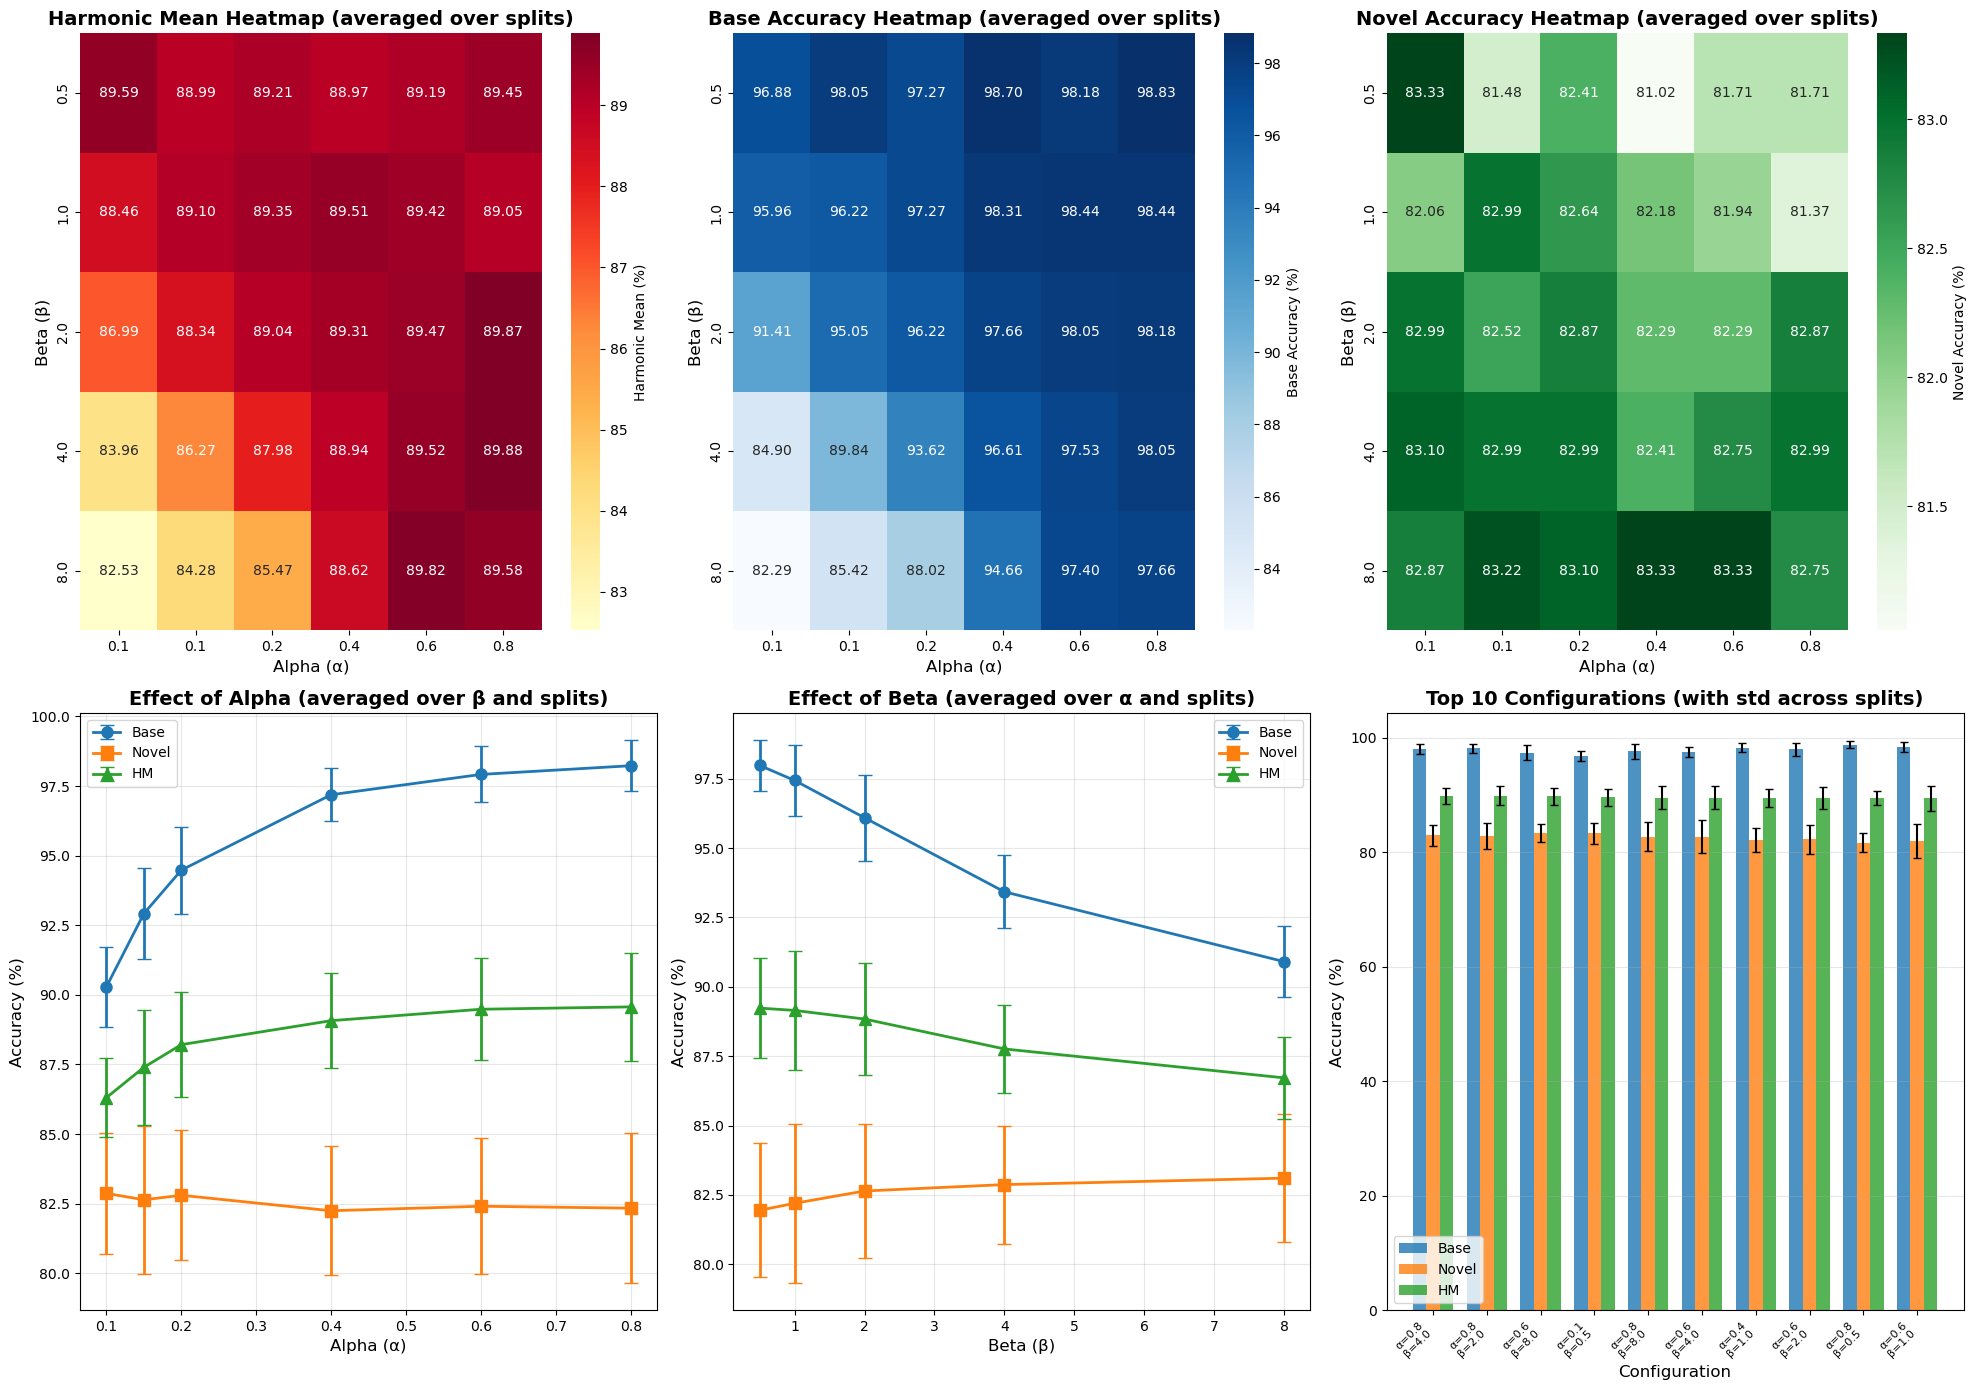


HYPERPARAMETER STUDY SUMMARY

🏆 Best Configuration (by Harmonic Mean):
   Alpha: 0.8
   Beta: 4
   Base Accuracy: 98.05% (±0.84%)
   Novel Accuracy: 82.99% (±1.86%)
   Harmonic Mean: 89.88% (±1.41%)

   Split scores:
     Split 1: Base=98.44%, Novel=82.64%, HM=89.85%
     Split 2: Base=98.83%, Novel=85.42%, HM=91.63%
     Split 3: Base=96.88%, Novel=80.90%, HM=88.17%

📊 Overall Statistics:
   Mean HM: 88.34% (±1.75%)
   Max HM: 89.88%
   Min HM: 82.53%
   Range: 7.36%

📈 Best Base Accuracy:
   Alpha: 0.8, Beta: 0.5
   Accuracy: 98.83% (±0.55%)

🎯 Best Novel Accuracy:
   Alpha: 0.1, Beta: 0.5
   Accuracy: 83.33% (±1.86%)

📉 Most Stable Configuration (lowest HM std):
   Alpha: 0.1, Beta: 4
   HM: 83.96% (±0.67%)

🏅 Top 5 Configurations (detailed):

1. Alpha=0.80, Beta=4.0
   Base: 98.05% (±0.84%)
   Novel: 82.99% (±1.86%)
   HM: 89.88% (±1.41%)

2. Alpha=0.80, Beta=2.0
   Base: 98.18% (±0.80%)
   Novel: 82.87% (±2.27%)
   HM: 89.87% (±1.67%)

3. Alpha=0.60, Beta=8.0
   Base: 97.40% (±1.

In [16]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

# Load results
results_file = "./logs/hyperparam_study_results.json" 
with open(results_file, "r") as f:
    results = json.load(f)

experiments = results["experiments"]

# Extract data (using mean values from splits)
alphas = [exp["hyperparameters"]["alpha"] for exp in experiments]
betas = [exp["hyperparameters"]["beta"] for exp in experiments]
base_accs_mean = [exp["metrics"]["base_accuracy_mean"] * 100 for exp in experiments]
novel_accs_mean = [exp["metrics"]["novel_accuracy_mean"] * 100 for exp in experiments]
hms_mean = [exp["metrics"]["harmonic_mean"] * 100 for exp in experiments]

# Extract std for error bars
base_accs_std = [exp["metrics"]["base_accuracy_std"] * 100 for exp in experiments]
novel_accs_std = [exp["metrics"]["novel_accuracy_std"] * 100 for exp in experiments]
hms_std = [exp["metrics"]["harmonic_mean_std"] * 100 for exp in experiments]

# Get unique alpha and beta values
unique_alphas = sorted(set(alphas))
unique_betas = sorted(set(betas))

# Create matrices for heatmaps
def create_matrix(alphas, betas, values, unique_alphas, unique_betas):
    matrix = np.zeros((len(unique_betas), len(unique_alphas)))
    for a, b, v in zip(alphas, betas, values):
        i = unique_betas.index(b)
        j = unique_alphas.index(a)
        matrix[i, j] = v
    return matrix

hm_matrix = create_matrix(alphas, betas, hms_mean, unique_alphas, unique_betas)
base_matrix = create_matrix(alphas, betas, base_accs_mean, unique_alphas, unique_betas)
novel_matrix = create_matrix(alphas, betas, novel_accs_mean, unique_alphas, unique_betas)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 14))

# 1. Harmonic Mean Heatmap
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(hm_matrix, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=[f'{a:.1f}' for a in unique_alphas],
            yticklabels=[f'{b:.1f}' for b in unique_betas],
            cbar_kws={'label': 'Harmonic Mean (%)'}, ax=ax1,
            vmax=hm_matrix.max())
ax1.set_xlabel('Alpha (α)', fontsize=12)
ax1.set_ylabel('Beta (β)', fontsize=12)
ax1.set_title('Harmonic Mean Heatmap (averaged over splits)', fontsize=14, fontweight='bold')

# 2. Base Accuracy Heatmap
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(base_matrix, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[f'{a:.1f}' for a in unique_alphas],
            yticklabels=[f'{b:.1f}' for b in unique_betas],
            cbar_kws={'label': 'Base Accuracy (%)'}, ax=ax2,
             vmax=base_matrix.max())
ax2.set_xlabel('Alpha (α)', fontsize=12)
ax2.set_ylabel('Beta (β)', fontsize=12)
ax2.set_title('Base Accuracy Heatmap (averaged over splits)', fontsize=14, fontweight='bold')

# 3. Novel Accuracy Heatmap
ax3 = plt.subplot(2, 3, 3)
sns.heatmap(novel_matrix, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=[f'{a:.1f}' for a in unique_alphas],
            yticklabels=[f'{b:.1f}' for b in unique_betas],
            cbar_kws={'label': 'Novel Accuracy (%)'}, ax=ax3,
            vmax=novel_matrix.max())
ax3.set_xlabel('Alpha (α)', fontsize=12)
ax3.set_ylabel('Beta (β)', fontsize=12)
ax3.set_title('Novel Accuracy Heatmap (averaged over splits)', fontsize=14, fontweight='bold')

# 4. Alpha effect (averaged over beta) WITH ERROR BARS
ax4 = plt.subplot(2, 3, 4)
alpha_groups = {}
for a, b, hm, base, novel, hm_std, base_std, novel_std in zip(
    alphas, betas, hms_mean, base_accs_mean, novel_accs_mean,
    hms_std, base_accs_std, novel_accs_std
):
    if a not in alpha_groups:
        alpha_groups[a] = {
            'hm': [], 'base': [], 'novel': [],
            'hm_std': [], 'base_std': [], 'novel_std': []
        }
    alpha_groups[a]['hm'].append(hm)
    alpha_groups[a]['base'].append(base)
    alpha_groups[a]['novel'].append(novel)
    alpha_groups[a]['hm_std'].append(hm_std)
    alpha_groups[a]['base_std'].append(base_std)
    alpha_groups[a]['novel_std'].append(novel_std)

alpha_stats = {
    k: {
        'hm_mean': np.mean(v['hm']),
        'base_mean': np.mean(v['base']),
        'novel_mean': np.mean(v['novel']),
        'hm_std': np.sqrt(np.mean(np.array(v['hm_std'])**2)),  # Pooled std
        'base_std': np.sqrt(np.mean(np.array(v['base_std'])**2)),
        'novel_std': np.sqrt(np.mean(np.array(v['novel_std'])**2))
    }
    for k, v in alpha_groups.items()
}

sorted_alphas = sorted(alpha_stats.keys())
ax4.errorbar(sorted_alphas, 
             [alpha_stats[a]['base_mean'] for a in sorted_alphas],
             yerr=[alpha_stats[a]['base_std'] for a in sorted_alphas],
             marker='o', label='Base', linewidth=2, markersize=8, capsize=5)
ax4.errorbar(sorted_alphas, 
             [alpha_stats[a]['novel_mean'] for a in sorted_alphas],
             yerr=[alpha_stats[a]['novel_std'] for a in sorted_alphas],
             marker='s', label='Novel', linewidth=2, markersize=8, capsize=5)
ax4.errorbar(sorted_alphas, 
             [alpha_stats[a]['hm_mean'] for a in sorted_alphas],
             yerr=[alpha_stats[a]['hm_std'] for a in sorted_alphas],
             marker='^', label='HM', linewidth=2, markersize=8, capsize=5)
ax4.set_xlabel('Alpha (α)', fontsize=12)
ax4.set_ylabel('Accuracy (%)', fontsize=12)
ax4.set_title('Effect of Alpha (averaged over β and splits)', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Beta effect (averaged over alpha) WITH ERROR BARS
ax5 = plt.subplot(2, 3, 5)
beta_groups = {}
for a, b, hm, base, novel, hm_std, base_std, novel_std in zip(
    alphas, betas, hms_mean, base_accs_mean, novel_accs_mean,
    hms_std, base_accs_std, novel_accs_std
):
    if b not in beta_groups:
        beta_groups[b] = {
            'hm': [], 'base': [], 'novel': [],
            'hm_std': [], 'base_std': [], 'novel_std': []
        }
    beta_groups[b]['hm'].append(hm)
    beta_groups[b]['base'].append(base)
    beta_groups[b]['novel'].append(novel)
    beta_groups[b]['hm_std'].append(hm_std)
    beta_groups[b]['base_std'].append(base_std)
    beta_groups[b]['novel_std'].append(novel_std)

beta_stats = {
    k: {
        'hm_mean': np.mean(v['hm']),
        'base_mean': np.mean(v['base']),
        'novel_mean': np.mean(v['novel']),
        'hm_std': np.sqrt(np.mean(np.array(v['hm_std'])**2)),
        'base_std': np.sqrt(np.mean(np.array(v['base_std'])**2)),
        'novel_std': np.sqrt(np.mean(np.array(v['novel_std'])**2))
    }
    for k, v in beta_groups.items()
}

sorted_betas = sorted(beta_stats.keys())
ax5.errorbar(sorted_betas, 
             [beta_stats[b]['base_mean'] for b in sorted_betas],
             yerr=[beta_stats[b]['base_std'] for b in sorted_betas],
             marker='o', label='Base', linewidth=2, markersize=8, capsize=5)
ax5.errorbar(sorted_betas, 
             [beta_stats[b]['novel_mean'] for b in sorted_betas],
             yerr=[beta_stats[b]['novel_std'] for b in sorted_betas],
             marker='s', label='Novel', linewidth=2, markersize=8, capsize=5)
ax5.errorbar(sorted_betas, 
             [beta_stats[b]['hm_mean'] for b in sorted_betas],
             yerr=[beta_stats[b]['hm_std'] for b in sorted_betas],
             marker='^', label='HM', linewidth=2, markersize=8, capsize=5)
ax5.set_xlabel('Beta (β)', fontsize=12)
ax5.set_ylabel('Accuracy (%)', fontsize=12)
ax5.set_title('Effect of Beta (averaged over α and splits)', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Top configurations comparison WITH ERROR BARS
ax6 = plt.subplot(2, 3, 6)
sorted_exps = sorted(experiments, key=lambda x: x["metrics"]["harmonic_mean"], reverse=True)
top_n = 10
top_configs = [f"α={e['hyperparameters']['alpha']:.1f}\nβ={e['hyperparameters']['beta']:.1f}" 
               for e in sorted_exps[:top_n]]
top_base = [e["metrics"]["base_accuracy_mean"] * 100 for e in sorted_exps[:top_n]]
top_novel = [e["metrics"]["novel_accuracy_mean"] * 100 for e in sorted_exps[:top_n]]
top_hm = [e["metrics"]["harmonic_mean"] * 100 for e in sorted_exps[:top_n]]
top_base_std = [e["metrics"]["base_accuracy_std"] * 100 for e in sorted_exps[:top_n]]
top_novel_std = [e["metrics"]["novel_accuracy_std"] * 100 for e in sorted_exps[:top_n]]
top_hm_std = [e["metrics"]["harmonic_mean_std"] * 100 for e in sorted_exps[:top_n]]

x = np.arange(top_n)
width = 0.25
ax6.bar(x - width, top_base, width, label='Base', alpha=0.8,
        yerr=top_base_std, capsize=3)
ax6.bar(x, top_novel, width, label='Novel', alpha=0.8,
        yerr=top_novel_std, capsize=3)
ax6.bar(x + width, top_hm, width, label='HM', alpha=0.8,
        yerr=top_hm_std, capsize=3)
ax6.set_xlabel('Configuration', fontsize=12)
ax6.set_ylabel('Accuracy (%)', fontsize=12)
ax6.set_title(f'Top {top_n} Configurations (with std across splits)', fontsize=14, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(top_configs, rotation=45, ha='right', fontsize=8)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('hyperparam_study_analysis.png', dpi=500, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("HYPERPARAMETER STUDY SUMMARY")
print("="*60)

best_exp = sorted_exps[0]
print(f"\n🏆 Best Configuration (by Harmonic Mean):")
print(f"   Alpha: {best_exp['hyperparameters']['alpha']}")
print(f"   Beta: {best_exp['hyperparameters']['beta']}")
print(f"   Base Accuracy: {best_exp['metrics']['base_accuracy_mean']*100:.2f}% "
      f"(±{best_exp['metrics']['base_accuracy_std']*100:.2f}%)")
print(f"   Novel Accuracy: {best_exp['metrics']['novel_accuracy_mean']*100:.2f}% "
      f"(±{best_exp['metrics']['novel_accuracy_std']*100:.2f}%)")
print(f"   Harmonic Mean: {best_exp['metrics']['harmonic_mean']*100:.2f}% "
      f"(±{best_exp['metrics']['harmonic_mean_std']*100:.2f}%)")

# Print split scores for best config
print(f"\n   Split scores:")
for i, (base, novel, hm) in enumerate(zip(
    best_exp['split_scores']['base_scores'],
    best_exp['split_scores']['novel_scores'],
    best_exp['split_scores']['hm_scores']
), 1):
    print(f"     Split {i}: Base={base*100:.2f}%, Novel={novel*100:.2f}%, HM={hm*100:.2f}%")

print(f"\n📊 Overall Statistics:")
print(f"   Mean HM: {np.mean(hms_mean):.2f}% (±{np.mean(hms_std):.2f}%)")
print(f"   Max HM: {np.max(hms_mean):.2f}%")
print(f"   Min HM: {np.min(hms_mean):.2f}%")
print(f"   Range: {np.max(hms_mean) - np.min(hms_mean):.2f}%")

print(f"\n📈 Best Base Accuracy:")
best_base = sorted(experiments, key=lambda x: x["metrics"]["base_accuracy_mean"], reverse=True)[0]
print(f"   Alpha: {best_base['hyperparameters']['alpha']}, Beta: {best_base['hyperparameters']['beta']}")
print(f"   Accuracy: {best_base['metrics']['base_accuracy_mean']*100:.2f}% "
      f"(±{best_base['metrics']['base_accuracy_std']*100:.2f}%)")

print(f"\n🎯 Best Novel Accuracy:")
best_novel = sorted(experiments, key=lambda x: x["metrics"]["novel_accuracy_mean"], reverse=True)[0]
print(f"   Alpha: {best_novel['hyperparameters']['alpha']}, Beta: {best_novel['hyperparameters']['beta']}")
print(f"   Accuracy: {best_novel['metrics']['novel_accuracy_mean']*100:.2f}% "
      f"(±{best_novel['metrics']['novel_accuracy_std']*100:.2f}%)")

print(f"\n📉 Most Stable Configuration (lowest HM std):")
most_stable = sorted(experiments, key=lambda x: x["metrics"]["harmonic_mean_std"])[0]
print(f"   Alpha: {most_stable['hyperparameters']['alpha']}, Beta: {most_stable['hyperparameters']['beta']}")
print(f"   HM: {most_stable['metrics']['harmonic_mean']*100:.2f}% "
      f"(±{most_stable['metrics']['harmonic_mean_std']*100:.2f}%)")

# Print top 5 with detailed stats
print(f"\n🏅 Top 5 Configurations (detailed):")
for i, exp in enumerate(sorted_exps[:5], 1):
    print(f"\n{i}. Alpha={exp['hyperparameters']['alpha']:.2f}, "
          f"Beta={exp['hyperparameters']['beta']:.1f}")
    print(f"   Base: {exp['metrics']['base_accuracy_mean']*100:.2f}% "
          f"(±{exp['metrics']['base_accuracy_std']*100:.2f}%)")
    print(f"   Novel: {exp['metrics']['novel_accuracy_mean']*100:.2f}% "
          f"(±{exp['metrics']['novel_accuracy_std']*100:.2f}%)")
    print(f"   HM: {exp['metrics']['harmonic_mean']*100:.2f}% "
          f"(±{exp['metrics']['harmonic_mean_std']*100:.2f}%)")

print("\n" + "="*60)